# Boston and Seattle AirBnB Datasets - Data Analysis
* Author: Jared Thacker

## Business Understanding
In this notebook I continue where the first notebook (the data cleaning portion) left off. In this notebook I analyze the clean airbnb dataset.

The business scenario/setting is an individual/entrepreneur who would like to purchase an extra property (a 2 bedroom, 1 bathroom property) to list on airbnb in an effort generate an extra stream of income. Not knowing anything about this space this individual decides to download data from a couple of large US cities (Boston and Seattle) and wants to understand the relationships between some of the variables/features provided.

## Analyze
Under the assumptions of this business perspective, it is inappropriate to seek a machine-learning (ML) model that is as accurate as possible; the goal is to understand the relationships that several of the intuitive variables have with the price of the property and what might contribute to a property staying booked so that it continues to generate income; a property with no guests is a property that is losing money.

The analysis consists of _three main_ questions and uses both data visualization and statistical (not machine-learning) models: a ordinary least squares (OLS) multiple linear regression (for daily price of the property). The regresion model is interpreted and the adequacy of the fit is checked. There are questions that are asked and answered in the EDA portion of this analysis, but the questions in this section are to (1) determine if a variable should be included in the regression model or (2) out of curiosity and are not the focus of the notebook. The questions that _are_ the focus in this notebook are annotated with 'Question #' in the table of contents.

I've briefly talked about one of the questions (relationship with rental price and a few other variables) using the regression model; below I discuss the overall picture of the next two questions.

For understanding the geospatial relationship of the number of vacancies a property has and price, _two_ choropleths are given and interpreted. In addition, maps showing the concentration of property locations in both Boston and Seattle are given.

Lastly, for understanding _good_ and _bad_ reviews a _word cloud_ is generated and displayed containing the top 50 words/phrases in a each set of reviews.

## Table of Contents

1. [Imports](#imports)<br>
2. [Gathering](#gathering)<br>
3. [Exploratory Data Analysis (EDA)](#questions)<br>
   a. [EDA: Price vs. # of Guests](#q1)<br>
   b. [EDA: Price vs. Review Value Scores](#q2)<br>
   c. [EDA: Price vs. # of Amenities](#q3)<br>
   d. [EDA: Price vs. City](#q4)<br>
   e. [EDA: Prices vs. # Bedrooms/Bathrooms](#q5)<br>
   f. [EDA: Price vs. Property Type](#q6)<br>
   g. [EDA: Price vs. Security Deposit](#bq1)<br>
   h. [EDA: Review Scores Value vs. Host Response Time](#bq2)<br>
   i. [EDA: Review Scores Value vs. Cancellation Policy](#bq3)<br>
   j. [EDA: Review Scores Value vs. Amount of Missing Data of a Property Listing](#bq4)<br>
4. [Model: Linear Modeling of Average Yearly Rental Price](#model)
5. [Question 1: Relationship Between Mean Price and Several Variables](#relationship)<br>
6. [Question 1:Modeling Mean Price](#regression)<br>
   a. [Checking Model Adequacy](#cma)<br>
   b. [Assumption 1](#ca1)<br>
   c. [Assumption 2](#ca2)<br>
   d. [Assumption 3](#ca3)<br>
   e. [Assumption 4](#ca4)<br>
   f. [Model Prediction](#modelprediction)<br>
   g. [Interpretation of the coefficients](#coefficientsinterpretation)<br>
   i. [Model Predictions](#regressionpredictions)<br>
7. [Visualize: Choropleths and Word Clouds](#visualize)
8. [Question 2: How does the Zipcode that Property is Located In Affect Price and Vacancy?](#zipc)<br>
   a. [Boston, MA: Availability_365 and Price Choropleths](#choropleth1)<br>
   b. [Seattle, WA: Availability_365 and Price Choroplets](#choropleth2)<br>
9. [Question 3: Word Clouds of Good and Bad Reviews](#wordclouds)<br>
   a. [Word Cloud: Bad Reviews](#badreviews)<br>
   b. [Word Cloud: Good Reviews](#goodreviews)<br>

<img src="img/logo.png" alt="alt_text" align="left" width="600" height="600" />

<a id='imports'></a>

In [1]:
# Imports

# Import modules made by me
import pretty_plots.plots as pts

# Other imports (by smart open-sourcers)
import json
import nltk
#nltk.download('stopwords')

import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
import seaborn as sns
import missingno as msno
import statsmodels as sm
import statsmodels.stats.api as sms
from statsmodels.formula.api import ols, logit
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler
from wordcloud import WordCloud
from nltk.corpus import stopwords

<a id='gathering'></a>

In [2]:
# Load the JSON containing the data types for the merged calendar_listings dataset
with open('feat_types_merged_calendar_listings.json', 'r') as f:
    feat_types = json.load(f)

In [3]:
# Load the JSON containing the data types for the merged reviews dataset
with open('reviews_type_dict.json', 'r') as f:
    reviews_types = json.load(f)

In [4]:
# Load all of the different datasets as dataframe
calendar_listings = pd.read_csv('calendar_listings.csv', dtype=feat_types, parse_dates=['host_since'])
reviews = pd.read_csv('reviews_concatenated.csv', dtype=reviews_types, parse_dates=['date'])

# Load the .shp files for the city of Boston and Seattle datasets that will be used to make
# maps of Boston and Seattle
boston_zip_df = gpd.read_file('./zip_codes_boundaries/Boston/ZIP_Codes/ZIP_Codes.shp')
boston_boundaries = gpd.read_file('./city_boundaries/Boston/City_of_Boston_Boundary/City_of_Boston_Boundary.shp')
seattle_zip_df = gpd.read_file('./zip_codes_boundaries/Seattle/ZIP_Codes/ZIP_Codes.shp')

In [5]:
# Verify that the features in the calendar_listings dataframe have all the
# correct data types
calendar_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 67 columns):
 #   Column                            Non-Null Count  Dtype         
---  ------                            --------------  -----         
 0   id                                7403 non-null   object        
 1   name                              7403 non-null   object        
 2   summary                           7083 non-null   object        
 3   description                       7403 non-null   object        
 4   experiences_offered               7403 non-null   category      
 5   host_since                        7401 non-null   datetime64[ns]
 6   host_location                     7384 non-null   category      
 7   host_response_time                6409 non-null   category      
 8   host_response_rate                6409 non-null   float64       
 9   host_acceptance_rate              6159 non-null   float64       
 10  host_is_superhost                 7403 non-null 

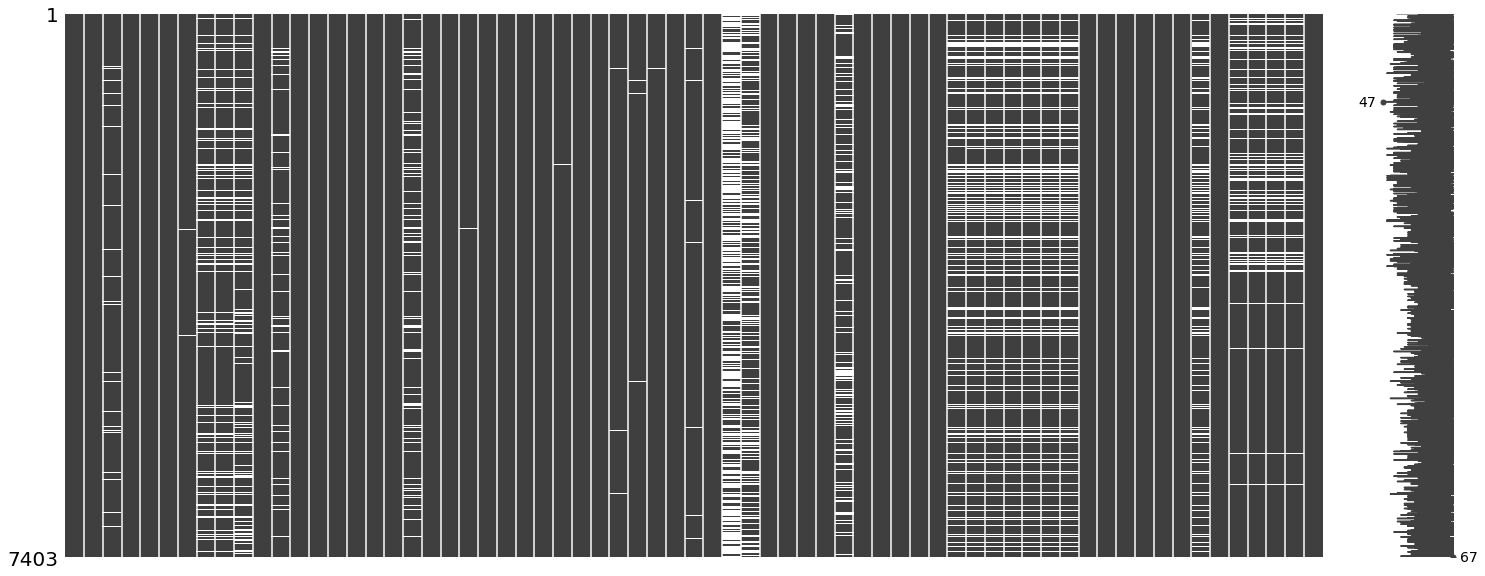

In [6]:
# Make a missingness matrix of the full calendar_listings dataset
msno.matrix(calendar_listings)
plt.show()

### (A little more) Missingness Analysis:
I did a analysis of this topic in the previous notebook, but I thought it was important to point out
that the review features **review_scores_rating**, **review_scores_cleanliness** etc. are all maximally correlated with one another indicating that when one review scores feature is missing, then they are all missing.

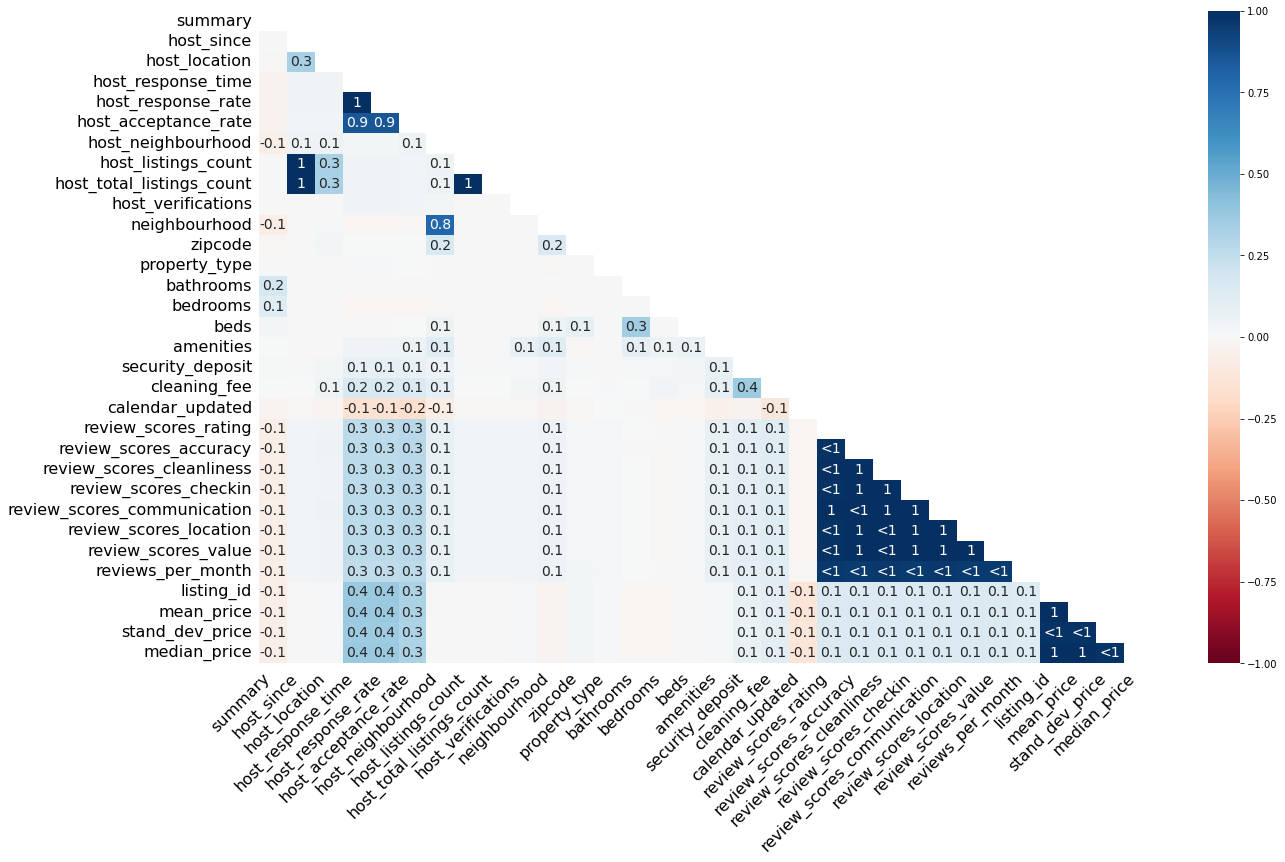

In [7]:
# Make a correlation heatmap of the relationship that the individual missingness
# of each feature has with other features (pairwise)
msno.heatmap(calendar_listings)
plt.show()

<a id='questions'></a>

## Analyze/Visualize: Explorate Data Analysis (EDA)

<a id='q1'></a>

### EDA: How does the number of guests included in an individuals stay affect the daily price of a property?

***Answer***: the barplot for the daily price vs the number of guests has an upward trend suggesting that as the number of guests that a property allows on the premises, the daily price of the property also increases. So, properties that allow more people will cost more - this is not only a intuitive, but a little obvious as well. We will quantify by how much the daily price of the property increases later in the notebook.

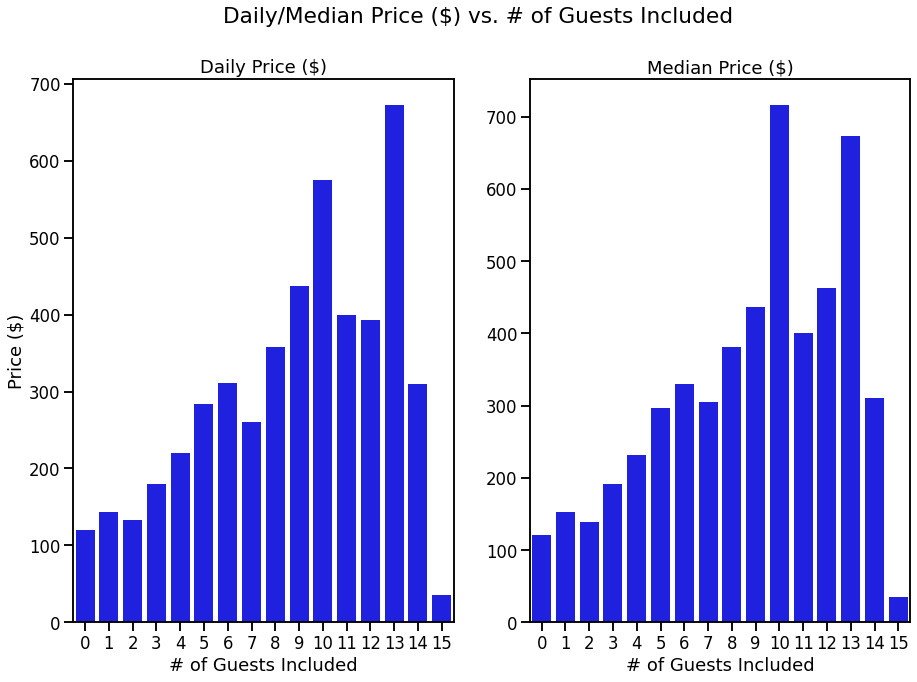

In [8]:
# Make exploratory barplot of price vs # of guests
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
info = {
    'x':'guests_included',
    'left_y':'price',
    'ci':None,
    'left_plot':ax[0],
    'right_plot':ax[1],
    'right_y':'median_price',
    'suptitle':'Daily/Median Price ($) vs. # of Guests Included',
    'left_xlabel':'# of Guests Included',
    'left_ylabel':'Price ($)',
    'left_title':'Daily Price ($)',
    'right_xlabel':'# of Guests Included',
    'right_ylabel':'',
    'right_title':'Median Price ($)',
    'figure':fig
}
pts.agg_price_bar_plots(calendar_listings, **info)

In [9]:
calendar_listings['review_scores_value'] = calendar_listings['review_scores_value'].cat.add_categories(['1.0'])

In [10]:
calendar_listings['review_scores_value'] = calendar_listings['review_scores_value'].cat.reorder_categories(['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0'])

<a id='q2'></a>

### EDA: does the review rating of property increase the daily price?

***answer***: it's unclear. Looking at the plot for daily/median price (below) we can see, if we ignore a review ratings of 2 and 4, that there is an increasing trend in the plot. _However_ both the review ratings of 2 and 4 throw off that trend in both of the plots for _daily_ and _median_ price suggesting that review ratings of 2 and 4 do actually have larger prices. Keep in mind that sample size for bad reviews (especially in the 2-4) range is relatively small, so this could be a sample size problem.

Since there does not seem to be a strong relationship between daily/median price and (I can't emphasize this enough) you can't directly control your **review_scores_value** I will not include this variable in the regression model.

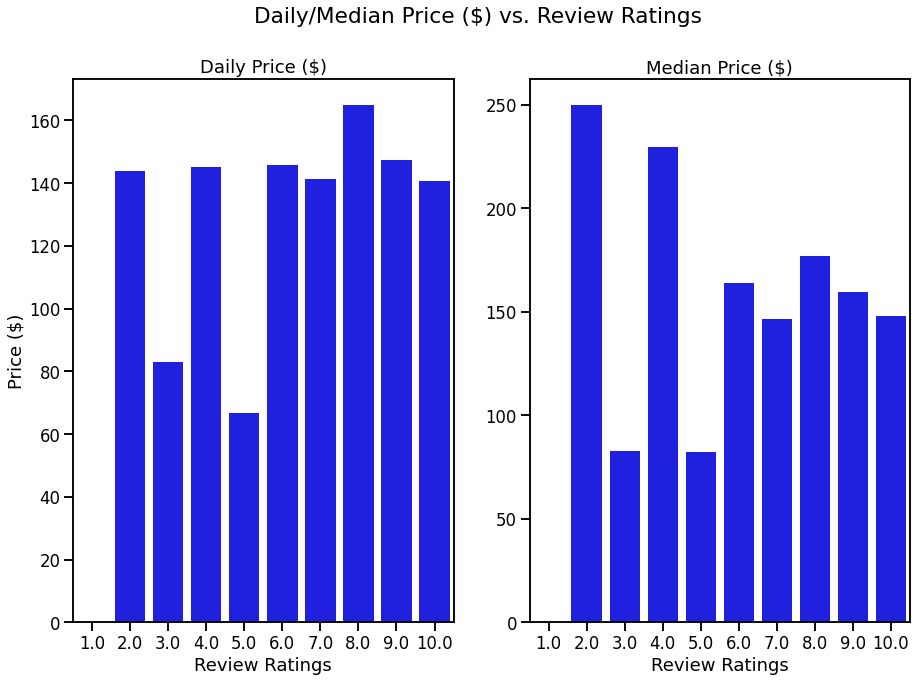

In [11]:
# Make a barplot of price vs. review scores value
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
info = {
    'x':'review_scores_value',
    'left_y':'price',
    'ci':None,
    'left_plot':ax[0],
    'right_plot':ax[1],
    'right_y':'median_price',
    'suptitle':'Daily/Median Price ($) vs. Review Ratings',
    'left_xlabel':'Review Ratings',
    'left_ylabel':'Price ($)',
    'left_title':'Daily Price ($)',
    'right_xlabel':'Review Ratings',
    'right_ylabel':'',
    'right_title':'Median Price ($)',
    'figure':fig
}
pts.agg_price_bar_plots(calendar_listings, **info)

<a id='q3'></a>

### EDA: does the daily price depend on the number of amenities the property provides

***answer***: There is an upward trend in the barplot for the number of amenities that a property offers. Interestingly, there is a sharp decrease in the price for both the daily price and the median price.

A possible explanation for this is that the owner of the property begins to list silly things that aren't really amenities. For example, below we have the amenities offered by two properties that 'offer' more than 30 amenities. One property offers _shampoo_ as an amenity while the other offers a _carbon monoxide detecor_ as an amenity; I believe that the average person would hardly consider these things amenities :D

### Feature Engineering Task
Make a feature that gives the number of amenities featured at each property.

In [12]:
calendar_listings['num_amenities'] = calendar_listings['amenities'].str.split('/').str.len()
calendar_listings['num_amenities_intervals'] = pd.cut(calendar_listings['num_amenities'], bins=[0, 5, 10, 15, 20, 25, 30, 35],
       labels=['0-5', '6-10', '11-15', '16-20', '21-25', '26-30', '31-35'])

In [13]:
example_amenities = list(calendar_listings.query('num_amenities  > 30')['amenities'].iloc[[0, 4]])
example_amenities

['TV/Cable TV/Internet/Wireless Internet/Air Conditioning/Wheelchair Accessible/Pool/Kitchen/Pets Allowed/Doorman/Gym/Breakfast/Elevator in Building/Hot Tub/Indoor Fireplace/Buzzer/Wireless Intercom/Heating/Washer/Dryer/Smoke Detector/Carbon Monoxide Detector/First Aid Kit/Safety Card/Fire Extinguisher/Shampoo/24-Hour Check-in/Hangers/Hair Dryer/Iron/Laptop Friendly Workspace',
 'TV/Cable TV/Internet/Wireless Internet/Air Conditioning/Wheelchair Accessible/Kitchen/Free Parking on Premises/Gym/Breakfast/Elevator in Building/Hot Tub/Indoor Fireplace/Buzzer/Wireless Intercom/Heating/Family/Kid Friendly/Washer/Dryer/Smoke Detector/Carbon Monoxide Detector/First Aid Kit/Safety Card/Fire Extinguisher/Essentials/Shampoo/24-Hour Check-in/Hangers/Hair Dryer/Iron/Laptop Friendly Workspace']

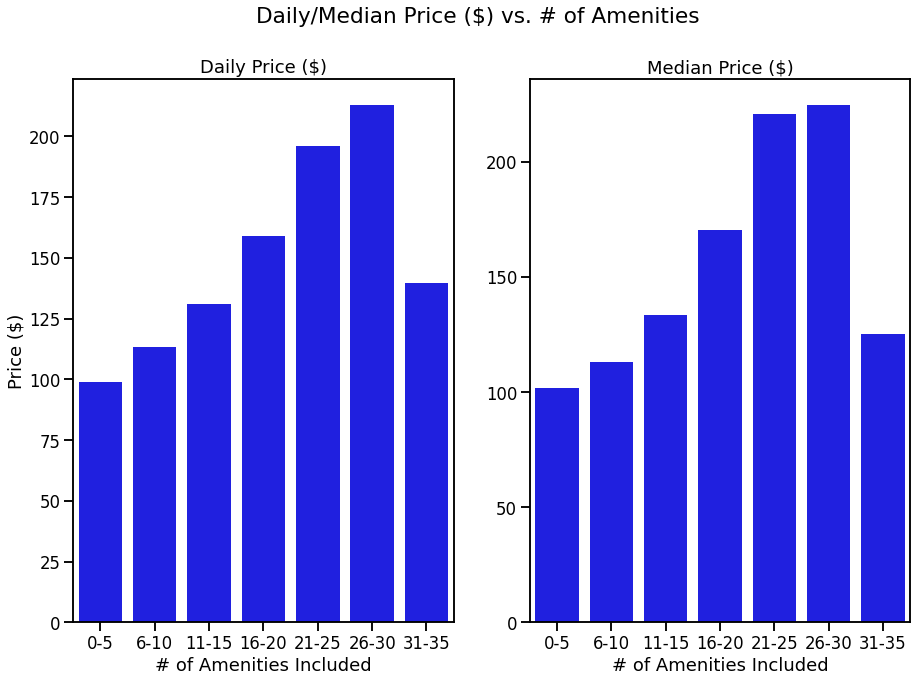

In [14]:
# Make barplot of price vs. # of amenities
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
info = {
    'x':'num_amenities_intervals',
    'left_y':'price',
    'ci':None,
    'left_plot':ax[0],
    'right_plot':ax[1],
    'right_y':'median_price',
    'suptitle':'Daily/Median Price ($) vs. # of Amenities',
    'left_xlabel':'# of Amenities Included',
    'left_ylabel':'Price ($)',
    'left_title':'Daily Price ($)',
    'right_xlabel':'# of Amenities Included',
    'right_ylabel':'',
    'right_title':'Median Price ($)',
    'figure':fig
}
pts.agg_price_bar_plots(calendar_listings, **info)

<a id='q4'></a>

### EDA: does the daily rental price of the property depend on the city?

***answer***: yes, from the barplot below, Boston seems to be a bit more expensive by about $50. In order to know if this difference is just by random chance, I calculated confidence intervals for the difference of two means between the two cities. From the confidence interval we can be 95\% confident that the true difference in daily rental price between properties in Boston and Seattle is between \\$40.93 - \\$51.51.

Lastly, another way to visualize this difference is if we provide Boxplots for the levels of city vs. daily rental price and then overlay the means as blue points on top of the boxplots.

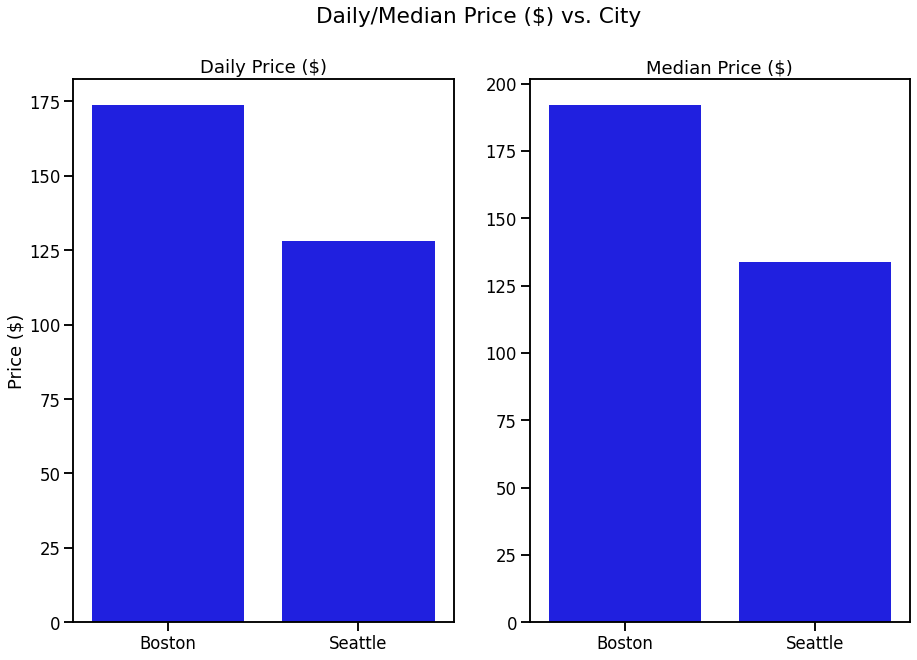

In [15]:
# Make a barplot of price vs. city
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
info = {
    'x':'city',
    'left_y':'price',
    'ci':None,
    'left_plot':ax[0],
    'right_plot':ax[1],
    'right_y':'median_price',
    'suptitle':'Daily/Median Price ($) vs. City',
    'left_xlabel':'',
    'left_ylabel':'Price ($)',
    'left_title':'Daily Price ($)',
    'right_xlabel':'',
    'right_ylabel':'',
    'right_title':'Median Price ($)',
    'figure':fig
}
pts.agg_price_bar_plots(calendar_listings, **info)

In [16]:
# 1. Make a two datasets: one for Boston and one for Seattle
# 2. Drop the missing values in each of these datasets
# 3. Find the groupedp means (by city) and make dataframe (not a Pandas.Series)
boston_properties = calendar_listings.query('city == "Boston"').dropna(subset=['mean_price']).copy(deep=True)
seattle_properties = calendar_listings.query('city == "Seattle"').dropna(subset=['mean_price']).copy(deep=True)
aggregate_city_price = calendar_listings.groupby('city').mean()['mean_price'].reset_index(name='mean_price')

In [17]:
# Give the standard deviation of in mean_price for each city
# The standard deviations are quite different indicating that we should use a
# difference of means hypothesis where the variances are assumed to be unequal
calendar_listings.groupby('city').std()['mean_price']

city
Boston     157.729807
Seattle     97.385682
Name: mean_price, dtype: float64

In [18]:
# Peform two-sample difference of mean hypothesis tests and display the results
comp_city_means = sms.CompareMeans(sms.DescrStatsW(boston_properties['mean_price']),
                 sms.DescrStatsW(seattle_properties['mean_price']))
print(comp_city_means.summary(usevar='unequal'))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1     61.1711      3.333     18.353      0.000      54.637      67.705


In [19]:
info_bplot_means = {'x':'city', 'y_wo_means':'price', 'box_color':'orange',
                    'y_w_means':'mean_price', 'mean_color':'blue', 'xlabel':'', 'ylabel':'Mean Price ($)',
                    'title':'Boxplots of Mean Price For Boston/Seattle', 'showfliers':False}

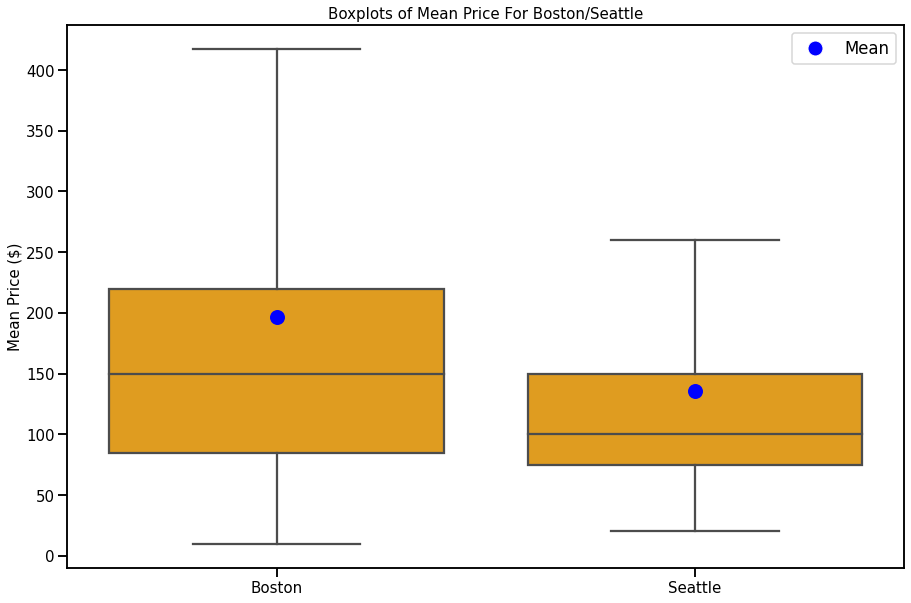

In [20]:
# Make a boxplot comparing median and mean of both cities to reinforce the results of the
# hypothesis test above
pts.box_plot_w_means(calendar_listings, aggregate_city_price, **info_bplot_means)

<a id='q5'></a>

### EDA: is there a relationship between the number of bedrooms/bathrooms and the daily rental price of a property?

***answer***: yes, there is an overall increasing trend in the pointplot below; as the number of bedrooms and bathrooms increases the daily/median price increases as well. We will quantify this relationship with ordinary least squares (OLS) regression later in this notebook.

### Feature Engineering Task
Make a feature that breaks up **bathrooms** (the number of bathrooms in a property) into discrete ordered intervals.

In [21]:
# bathrooms_intervals = number of bathrooms in a property in discrete ordered intervals
calendar_listings['bathrooms_intervals'] = pd.cut(calendar_listings['bathrooms'], bins=[-1, 2, 4, 9], labels=['0-1', '1-2', '2-4'])

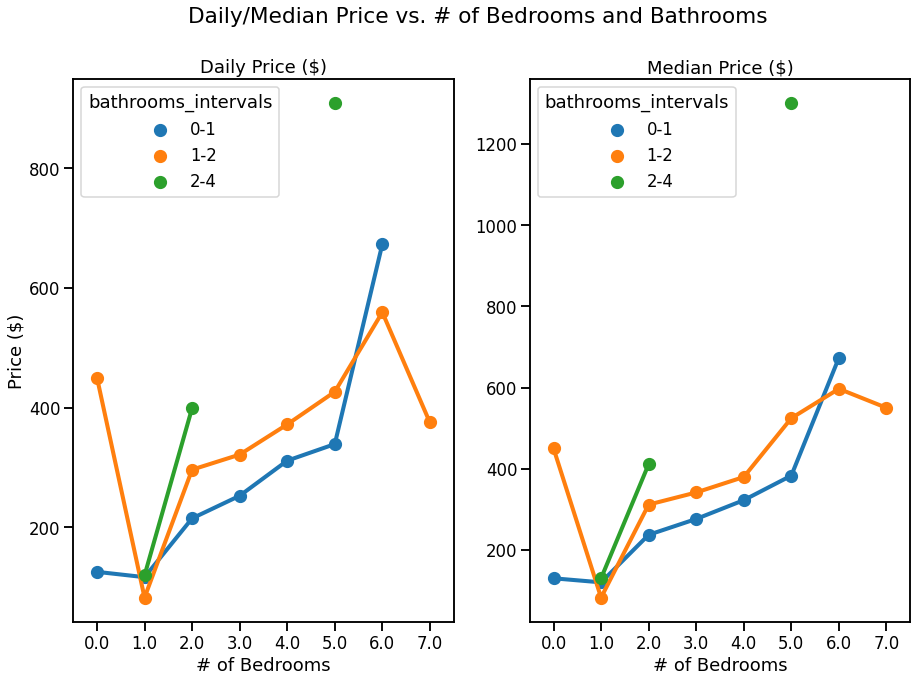

In [22]:
# Make a line plot comparing the price, number of bedrooms and bathrooms that
# a property has
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
info = {
    'x':'bedrooms',
    'left_y':'price',
    'right_y':'median_price',
    'hue':'bathrooms_intervals',
    'join':True,
    'left_title':'Daily Price ($)',
    'right_title':'Median Price ($)',
    'xlabel':'# of Bedrooms',
    'left_ylabel':'Price ($)',
    'right_ylabel':'',
    'suptitle':'Daily/Median Price vs. # of Bedrooms and Bathrooms',
    'left_plot':ax[0],
    'right_plot':ax[1],
    'figure':fig
}
pts.agg_price_point_plots(calendar_listings, **info)

<a id='q6'></a>

### EDA: Does property type have a relationship with the daily/median rental price of a property?

***answer***: Yes, apartments tend to be more expensive than houses according to the barplot of daily/median price vs. property type. I decided not to include this feature in the OLS regression since **property_type*** did not improve model fit by very much. Therefore I will provide confidence intervals for the differences of the means for apartments/houses below.

We can conclude from the confidence interval that we are 95\% confident that the true price difference between houses/apartments is in the range of \\$46.11 - \\$32.26.

In [23]:
# Make a list of property_type levels to remove
calendar_listings_sub_by_prop_type = calendar_listings.query('property_type == "Apartment" or property_type == "House"').copy(deep=True)
cats_to_remove = list(calendar_listings_sub_by_prop_type['property_type'].value_counts()[calendar_listings_sub_by_prop_type['property_type'].value_counts() < 1].index)

In [24]:
# Remove all levels of property_type that are not 'House' or 'Apartment'
calendar_listings_sub_by_prop_type['property_type'] = \
              calendar_listings_sub_by_prop_type['property_type'].cat.remove_categories(cats_to_remove)

In [25]:
calendar_listings_sub_by_prop_type['property_type'].value_counts(normalize=True)

Apartment    0.653061
House        0.346939
Name: property_type, dtype: float64

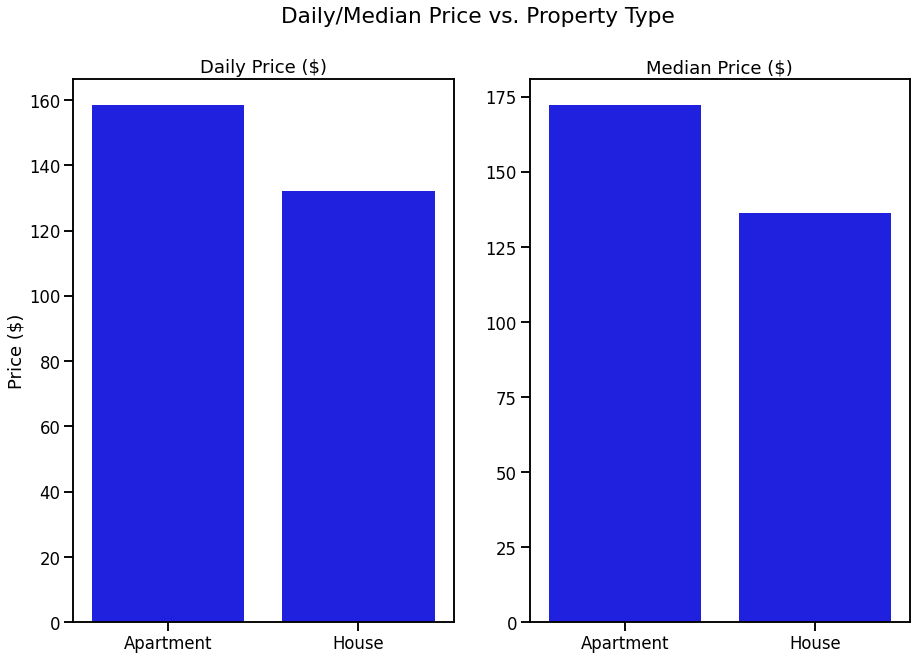

In [26]:
# Make a barplot of price vs. property type
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
info = {
    'x':'property_type',
    'left_y':'price',
    'right_y':'median_price',
    'ci':None,
    'left_plot':ax[0],
    'right_plot':ax[1],
    'left_xlabel':'',
    'right_xlabel':'',
    'right_ylabel':'',
    'left_ylabel':'Price ($)',
    'right_title':'Median Price ($)',
    'left_title':'Daily Price ($)',
    'suptitle':'Daily/Median Price vs. Property Type',
    'figure':fig
}
pts.agg_price_bar_plots(calendar_listings_sub_by_prop_type, **info)

In [27]:
# Compare the standard deviations of mean_price for the remaining two levels of property_type
# 'House' or 'Apartment'
calendar_listings_sub_by_prop_type.groupby('property_type')['mean_price'].std()

property_type
Apartment    134.424788
House        125.483955
Name: mean_price, dtype: float64

In [28]:
aggregate_mean_price = calendar_listings_sub_by_prop_type.groupby('property_type')['mean_price'].mean().reset_index(name='mean_price')

In [29]:
calendar_listings_house = calendar_listings_sub_by_prop_type.query('property_type == "House"')
calendar_listints_apartment = calendar_listings_sub_by_prop_type.query('property_type == "Apartment"')

In [30]:
# Perform two-sample test of the difference of means
comp_city_means = sms.CompareMeans(sms.DescrStatsW(calendar_listings_house['mean_price'].dropna()),
                 sms.DescrStatsW(calendar_listints_apartment['mean_price'].dropna()))
print(comp_city_means.summary(usevar='pooled'))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1    -39.1855      3.533    -11.093      0.000     -46.111     -32.260


In [31]:
info_bplot_means = {'x':'property_type', 'y_wo_means':'price', 'box_color':'orange',
                    'y_w_means':'mean_price', 'mean_color':'blue', 'xlabel':'', 'ylabel':'Mean Price ($)',
                    'title':'Boxplots of Mean Price For Apartments/House', 'showfliers':False}

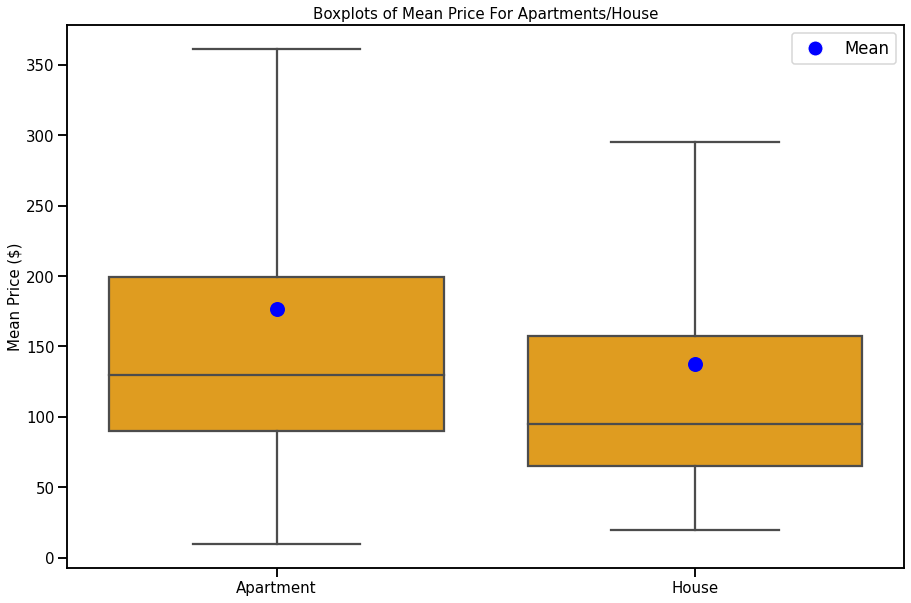

In [32]:
# Make a boxplot comparing the means/medians of price of Apartment/House
pts.box_plot_w_means(calendar_listings_sub_by_prop_type, aggregate_mean_price, **info_bplot_means)

<a id='bq1'></a>

### EDA: Do properties with higher rental prices have larger required security deposits?

***answer***: Yes, there is an _mild_ upward trend in the barplot below albeit not a very _strong_ upward trend.

### Feature Engineering Task
Make a feature that categorizes the amount the USD of the security that airbnb property requires

In [33]:
calendar_listings_sub_by_prop_type['security_deposit_intervals'] = pd.cut(calendar_listings_sub_by_prop_type['security_deposit'], bins=[-1, 100, 200, 300, 400, 500],
       labels=['0-100', '101-200', '201-300', '301-400', '400+'])

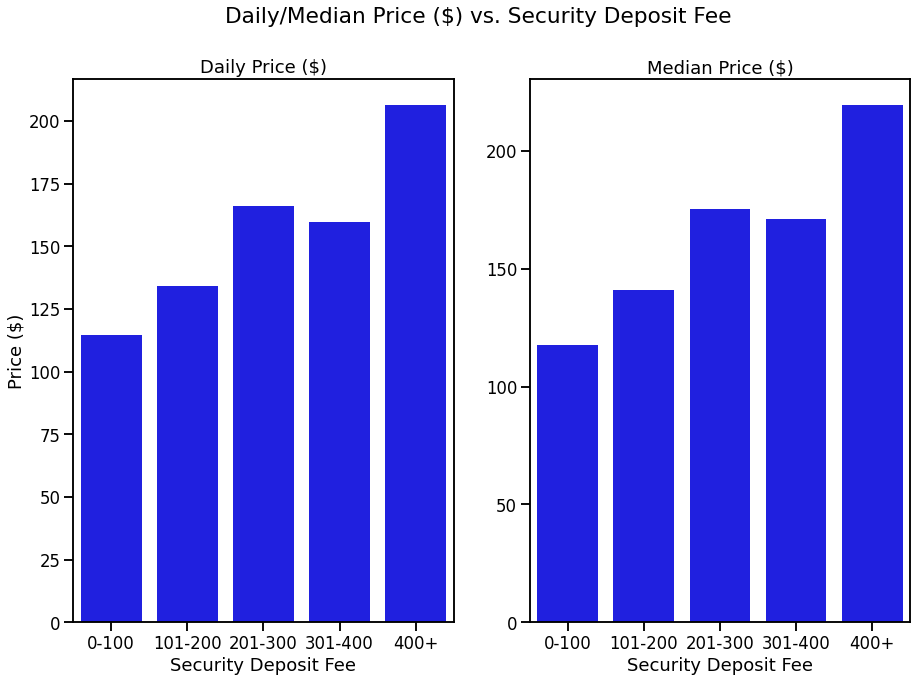

In [34]:
# Make a barplot of price vs security deposit fee
sns.set_context('talk')
fig, ax = plt.subplots(1, 2, figsize=[15, 10])
info = {
    'x':'security_deposit_intervals',
    'left_y':'price',
    'ci':None,
    'left_plot':ax[0],
    'right_plot':ax[1],
    'right_y':'median_price',
    'suptitle':'Daily/Median Price ($) vs. Security Deposit Fee',
    'left_xlabel':'Security Deposit Fee',
    'left_ylabel':'Price ($)',
    'left_title':'Daily Price ($)',
    'right_xlabel':'Security Deposit Fee',
    'right_ylabel':'',
    'right_title':'Median Price ($)',
    'figure':fig
}
pts.agg_price_bar_plots(calendar_listings_sub_by_prop_type, **info)

<a id='bq2'></a>

### EDA: Does host response time affect the review score that a property has?

***answer***: It doesn't seem like it. If we look at the frequency heat map below, we can see that for basically all response times levels that the vast majority of the reveiw scores are between 9 - 10. 

In [35]:
# Loaded categorical variables are unordered by default - reorder the categories
calendar_listings['host_response_time'] = calendar_listings['host_response_time'].cat.reorder_categories(['0-1', '1-3', '3-24', '24+'])

In [36]:
# Create a contingency table of review_scores_value vs. host_response_time
host_resp_v_reviews = pd.crosstab(
    calendar_listings['review_scores_value'],
    calendar_listings['host_response_time'] ,
                                 )

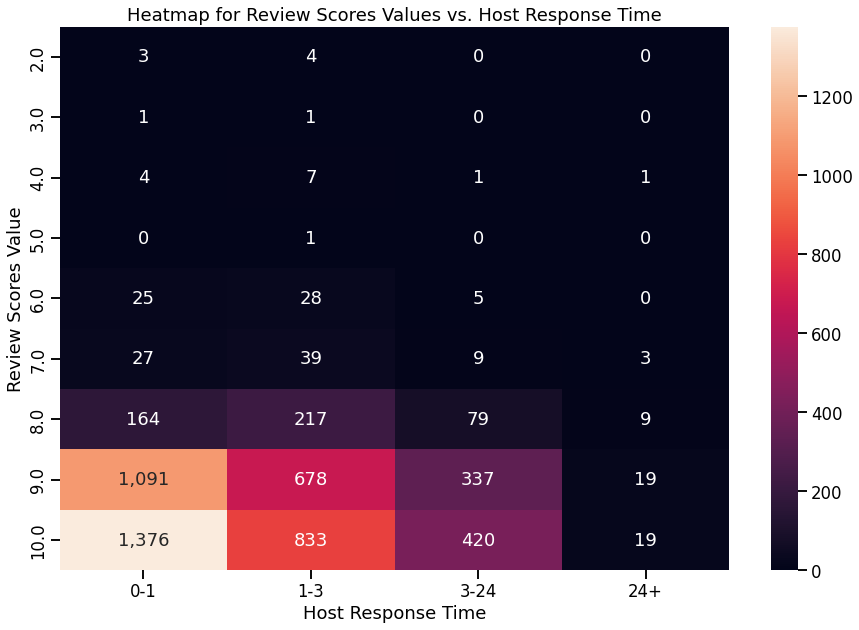

In [37]:
# Make a heatmap of the review_scores_value vs. host_response_time contingency table
sns.set_context('talk')
fig, ax = plt.subplots(figsize=[15, 10])
sns.heatmap(host_resp_v_reviews, annot=True, fmt=',')
ax.set(xlabel='Host Response Time', ylabel='Review Scores Value',
       title='Heatmap for Review Scores Values vs. Host Response Time')
plt.show()

<a id='bq3'></a>

### EDA: Does the cancellation policy time affect the review score that a property has?

***answer***: Again, there does not seem to be a trend for similar reason as for bonus question 2.

In [38]:
calendar_listings['cancellation_policy'] = calendar_listings['cancellation_policy'].cat.reorder_categories(['flexible', 'moderate', 'strict', 'super_strict_30'])

In [39]:
# Make a contingency table of review_scores_value vs. cancellation_policy
cancellation_v_reviews = pd.crosstab(
    calendar_listings['review_scores_value'],
    calendar_listings['cancellation_policy']    
                                 )

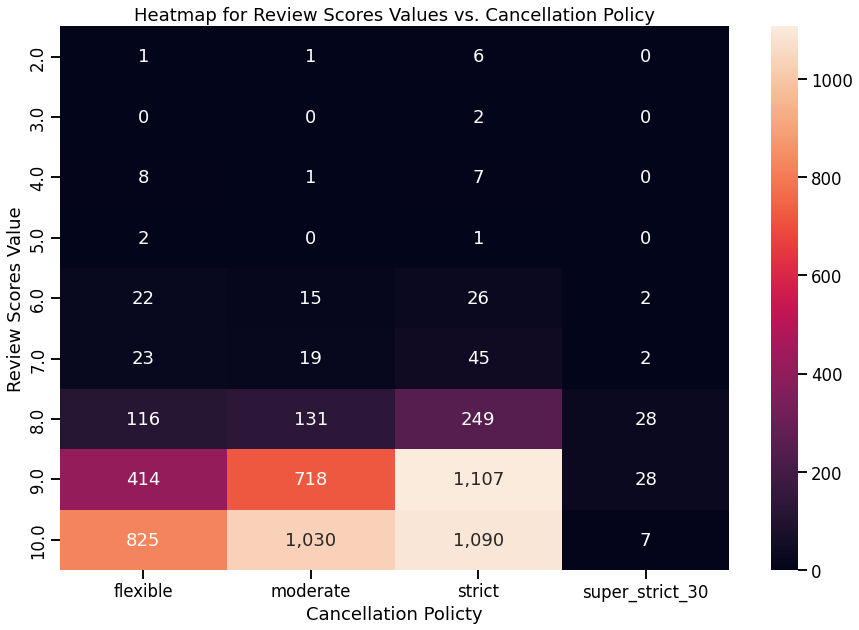

In [40]:
# Make a heatmap of review_scores_value vs. cancellation_policy
sns.set_context('talk')
fig, ax = plt.subplots(figsize=[15, 10])
sns.heatmap(cancellation_v_reviews, annot=True, fmt=',')
ax.set(xlabel='Cancellation Policty', ylabel='Review Scores Value',
       title='Heatmap for Review Scores Values vs. Cancellation Policy')
plt.show()

<a id='bq4'></a>

### EDA: Does the number of NaNs in a property listings' airbnb profile affect the review score that the property has?

***answer***: I would say _no_. According to the confidence interval there is a statistically significant difference between the two. _However_, this difference is between 2-3 missing values from the property's online profile. Is 2-3 missing pieces of information a lot? So, my answer on **review_scores_value** vs. **number_of_NAas** relationship is _no_.

I think it would be worth looking into is if there are 2-3 _specific_ pieces of information that are consitently missing from property listings that have low reviews - for future study.

### Feature Engineering Task
Make a feature that divides the properties into a 'high review' category and 'low review' category based on a threshold of review_scores_value

In [41]:
# Make a feature that divideds properties into two categories: 'High Review' and 'Low Review'
calendar_listings_drop = calendar_listings.dropna(subset=['review_scores_value']).copy(deep=True)
calendar_listings_drop.loc[:, 'is_high_review'] = calendar_listings_drop['review_scores_value'].cat.codes > 6
calendar_listings_drop.loc[:, 'is_high_review'] = calendar_listings_drop['is_high_review'].replace({True:'High Review', False:'Low Review'})

In [42]:
# Query the calendar_listings dataframe for properties that have > 7 and < 7 review_scores_value
low_reviews = calendar_listings_drop.query('review_scores_value not in ["8.0", "9.0", "10.0"]')
high_reviews = calendar_listings_drop.query('review_scores_value in ["8.0", "9.0", "10.0"]')

In [43]:
# Find the standard deviation of the number_of_NAs in the high_reviews dataframe and the low_reviews dataframe
calendar_listings_drop.groupby('is_high_review').std()['number_of_NAs']

is_high_review
High Review    4.107851
Low Review     4.739880
Name: number_of_NAs, dtype: float64

In [44]:
# Perform a two-sample hypothesis test on the number of missing values in properties that have high reviews
# vs. properties that have low reviews
comp_means = sms.CompareMeans(sms.DescrStatsW(low_reviews['number_of_NAs']),
                 sms.DescrStatsW(high_reviews['number_of_NAs']))
print(comp_means.summary(usevar='pooled'))

                          Test for equality of means                          
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
subset #1      2.3594      0.310      7.610      0.000       1.752       2.967


In [45]:
# Calculate and then display the mean number of missing values in a row for properties that have high/low reviews
group_means = calendar_listings_drop.groupby('is_high_review').mean()['number_of_NAs'].reset_index(name='mean_num_NAs')
group_means

,is_high_review,mean_num_NAs
0,High Review,8.072262
1,Low Review,10.431694


In [46]:
info_bplot_means = {'x':'is_high_review', 'y_wo_means':'number_of_NAs', 'box_color':'orange',
                    'y_w_means':'mean_num_NAs', 'mean_color':'blue', 'xlabel':'', 'ylabel':'# of NAs',
                    'title':'# of NAs vs High/Low Reviews', 'showfliers':False}

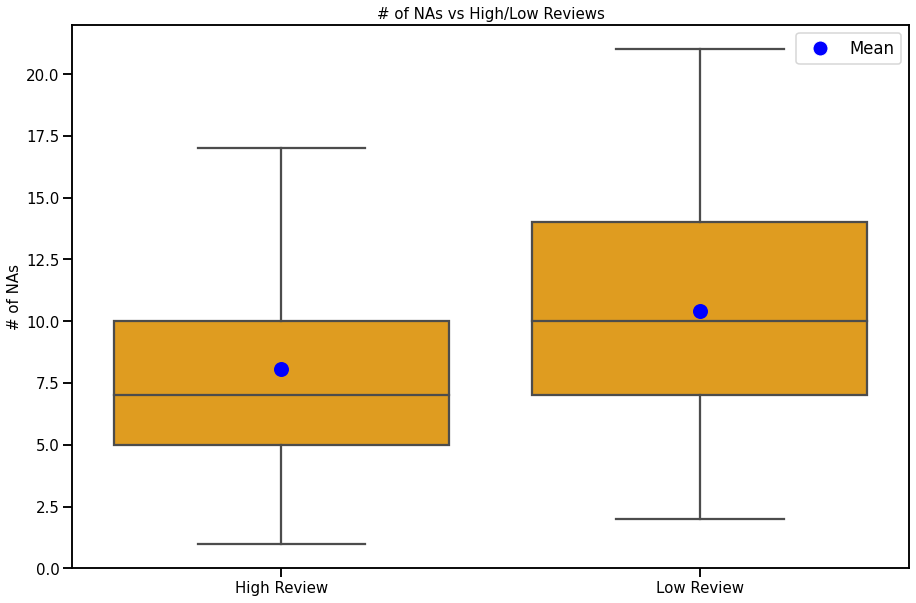

In [47]:
# Make a boxplot comparing the median/mean of number of missing values in a row vs. the level of 'is_high_review' 
pts.box_plot_w_means(calendar_listings_drop, group_means, **info_bplot_means)

<a id='model'></a>

## Model: Linear Modeling of Average Yearly Price

<a id='relationship'></a>

## Question 1: What is the relationship between the following variables?

   * Average rental price of a property (response)
   * Number of bedrooms a property has (regressor/predictor)
   * City that a property is located in (regressor/predictor)
   * Room type (regressor/predictor)
   * Number of amenities provided to the guest (regressor/predictor)
   * Number of bathrooms a property has (regressor/predictor)
   * The property type, e.g, is it a house of apartment (regressor/predictor)
   
Is there a discernible difference between the price of the two cities? How does the number of bedrooms a property has affect the price? Can we quantify these relationships?

<a id='regression'></a>

### Modeling: Linear Regression Modeling of the Mean Price of a Property Listing

Now that we have performed a little bit of EDA on how a few of the common/intuitive variables relate to the **mean_price** of a property listing, we would like to quantify that relationship. For example, by approximately how much should the price of a property increase for properties that have one additional bedroom? Bathrooms?

In the code cells that follow, I will assume that the reader is familiar with fitting regression models in Python (specifically with the statsmodels API) and I will interpret the model and explain any intricacies of the modeling process.

NOTE: As mentioned briefly in the introduction of this notebook, my intention with modeling **mean_price** is not to obtain an accurate model for predictive purposes; the intention is to understand the relationship between rental price and several of the variables that you could control when selecting a property that you will list on airbnb for rent. By thinking of the modeling this way, as you prepare to buy a property for renting, you can know what the quantitative effects of your selection process will have on the price _as_ you consider them. Therefore, there will be no resampling for estimating predictive power or model selection/feature selection for model flexibility performed as those are processes more associated with prediction, not inference (in general).

### Feature Engineering Task
Make a feature that gives the number of days that a particular host has been hosting guests on airbnb

In [48]:
calendar_listings_sub_by_prop_type['time_as_host'] = pd.to_datetime('today') - calendar_listings_sub_by_prop_type['host_since']
calendar_listings_sub_by_prop_type['time_as_host'] = calendar_listings_sub_by_prop_type['time_as_host'].dt.days

In the code cells below I fit _two_ OLS regression models to the five features that I have identified an individual would have the most control over as they are selecting a property to purchase.

The first regression model relates the **mean_price** to the predictors **bedrooms**, **city**, **room_type** and **bathrooms** while the second regression model relates the log transform, namely, **log_mean_price** to those same predictors. The reason for transforming **mean_price** to **log_mean_price** will become more apparent once we begin to check the _model adequacy_ of the _first_ and _second_ regression models - specifically it will be clear why I transformed **mean_price** when we look at residuals plots for both models. HINT: the variance of the response (**mean_price**) is _not_ constant.


NOTE: I have _prefiltered_ properties that are either a(n) apartment/house since these are the property types that are most common (by an overwhelming amount) and this is likely what the _vast_ majority of people would be considering to buy to list for rent.

In [49]:
# Fit a linear regression using OLS using the statsmodels API
lm = ols('mean_price ~ bedrooms + city + room_type + num_amenities + bathrooms + property_type', data=calendar_listings_sub_by_prop_type)

### Feature Engineering Task
Make a feature of the natural logarithm of **mean_price** 

In [50]:
# make a feature of the natural logarithm of mean_price
calendar_listings_sub_by_prop_type['log_mean_price'] = np.log(calendar_listings_sub_by_prop_type['mean_price'])

In [51]:
lm_log = ols('log_mean_price ~ bedrooms + city + room_type + num_amenities + bathrooms + property_type', data=calendar_listings_sub_by_prop_type)

From the RegressionResults object that the .fit() method returns, the regression model for the untransformed response of **mean_price** achieves an $R^2$ = 0.470 while the regression model for the log-transformed response achieves an $R^2$ = 0.648. Both of these statistics indicate that 47\% and 65\% of the variability in **mean_price** and **log_mean_price** (respectively) are explained by the regressor variables.

Both models have a large _F_ - statistic indicating a significance of regression (unlikely that all of the $\beta$s = 0). In addition, all of the coefficients pass their individual hypothesis tests indicating each individual coefficient is significant to the model.

In [52]:
# Display the RegressionResults.summary() for the linear model of mean_price
lm = lm.fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             mean_price   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     751.1
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:03:25   Log-Likelihood:                -34875.
No. Observations:                5825   AIC:                         6.977e+04
Df Residuals:                    5817   BIC:                         6.982e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    69.4921      5.818     11.945      0.000      58.087      80.897
city[T.Seattle]             -58.3633      2.793    -20.897      0.000     -63.838     -52.888
room_type[T.Private room]   -88.3212      3.155    -27.991      0.000     -94.507     -82.135
room_type[T.Shared room]   -104.2236      7.878    -13.229      0.000    -119.668     -88.779
property_type[T.House]      -22.9679      3.203     -7.171      0.000     -29.247     -16.689
bedrooms                     47.4893      1.963     24.195      0.000      43.642      51.337
num_amenities                 2.3430      0.273      8.572      0.000       1.807       2.879
bathrooms                    54.5801      3.056     17.857      0.000      48.588      60.572
==============================================================================
Omnibus:                    10475.184   Durbin-Watson:                   1.751
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         43255631.224
Skew:                          12.463   Prob(JB):                         0.00
Kurtosis:                     424.425   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [53]:
# Display the RegressionResults.summary() for the linear model of log_mean_price
lm_log = lm_log.fit()
lm_log.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         log_mean_price   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     1565.
Date:                Mon, 10 Jan 2022   Prob (F-statistic):               0.00
Time:                        17:03:25   Log-Likelihood:                -2695.9
No. Observations:                5825   AIC:                             5408.
Df Residuals:                    5817   BIC:                             5461.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.5880      0.023    197.724      0.000       4.543       4.634
city[T.Seattle]              -0.3011      0.011    -27.028      0.000      -0.323      -0.279
room_type[T.Private room]    -0.6891      0.013    -54.752      0.000      -0.714      -0.664
room_type[T.Shared room]     -0.9975      0.031    -31.743      0.000      -1.059      -0.936
property_type[T.House]       -0.1148      0.013     -8.982      0.000      -0.140      -0.090
bedrooms                      0.2232      0.008     28.505      0.000       0.208       0.239
num_amenities                 0.0152      0.001     13.898      0.000       0.013       0.017
bathrooms                     0.1725      0.012     14.148      0.000       0.149       0.196
==============================================================================
Omnibus:                      315.922   Durbin-Watson:                   1.569
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1082.712
Skew:                           0.180   Prob(JB):                    7.80e-236
Kurtosis:                       5.081   Cond. No.                         107.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<a id='cma'></a>

### Analyze: Check Model Adequacy and Assumptions of Each Regression Model
Since the residuals of the regression model can be thought of as the observed/estimated values of the model errors then we can check assumptions on the linear model by calculating some statistics on and visualizing the residuals.

<a id='ca1'></a>

#### Assumption 1: Error terms have mean 0 ( $\overline{\epsilon}$ = 0 )
From the code cells below, we can see that both models satisfy this criterion

In [54]:
# Calculate the mean of the residuals for the log of the mean_price response model
lm_log.resid.mean()

4.441227547860856e-14

In [55]:
# Calculate the mean of the residuals for the mean_price model
lm.resid.mean()

3.9472070056945084e-12

<a id='ca2'></a>

#### Assumption 2: Error Terms are uncorrelated
From the two scatter plots of $\epsilon_i$ vs. $\epsilon_{i-1}$ we see no visible trend in the residuals, so we reasonably conclude that the error terms are uncorrelated from this plot.

In [56]:
# Make a dataframe of the lag of each residual
no_transformation_resid = pd.DataFrame({'ep':lm.resid, 'ep_m_1':lm.resid.shift(),
                                        'transformation':'no_transformation'})
log_resid = pd.DataFrame({'ep':lm_log.resid, 'ep_m_1':lm_log.resid.shift(),
                                        'transformation':'logarithm'})
resid_combined = pd.concat([no_transformation_resid, log_resid], ignore_index=True)
resid_combined

,ep,ep_m_1,transformation
0,-66.972603,NaN,no_transformation
1,-60.414021,-66.972603,no_transformation
2,-39.161086,-60.414021,no_transformation
3,-41.364229,-39.161086,no_transformation
4,-90.264486,-41.364229,no_transformation
...,...,...,...
11645,-0.352669,-0.693567,logarithm
11646,0.439105,-0.352669,logarithm
11647,-0.348150,0.439105,logarithm
11648,-0.394839,-0.348150,logarithm


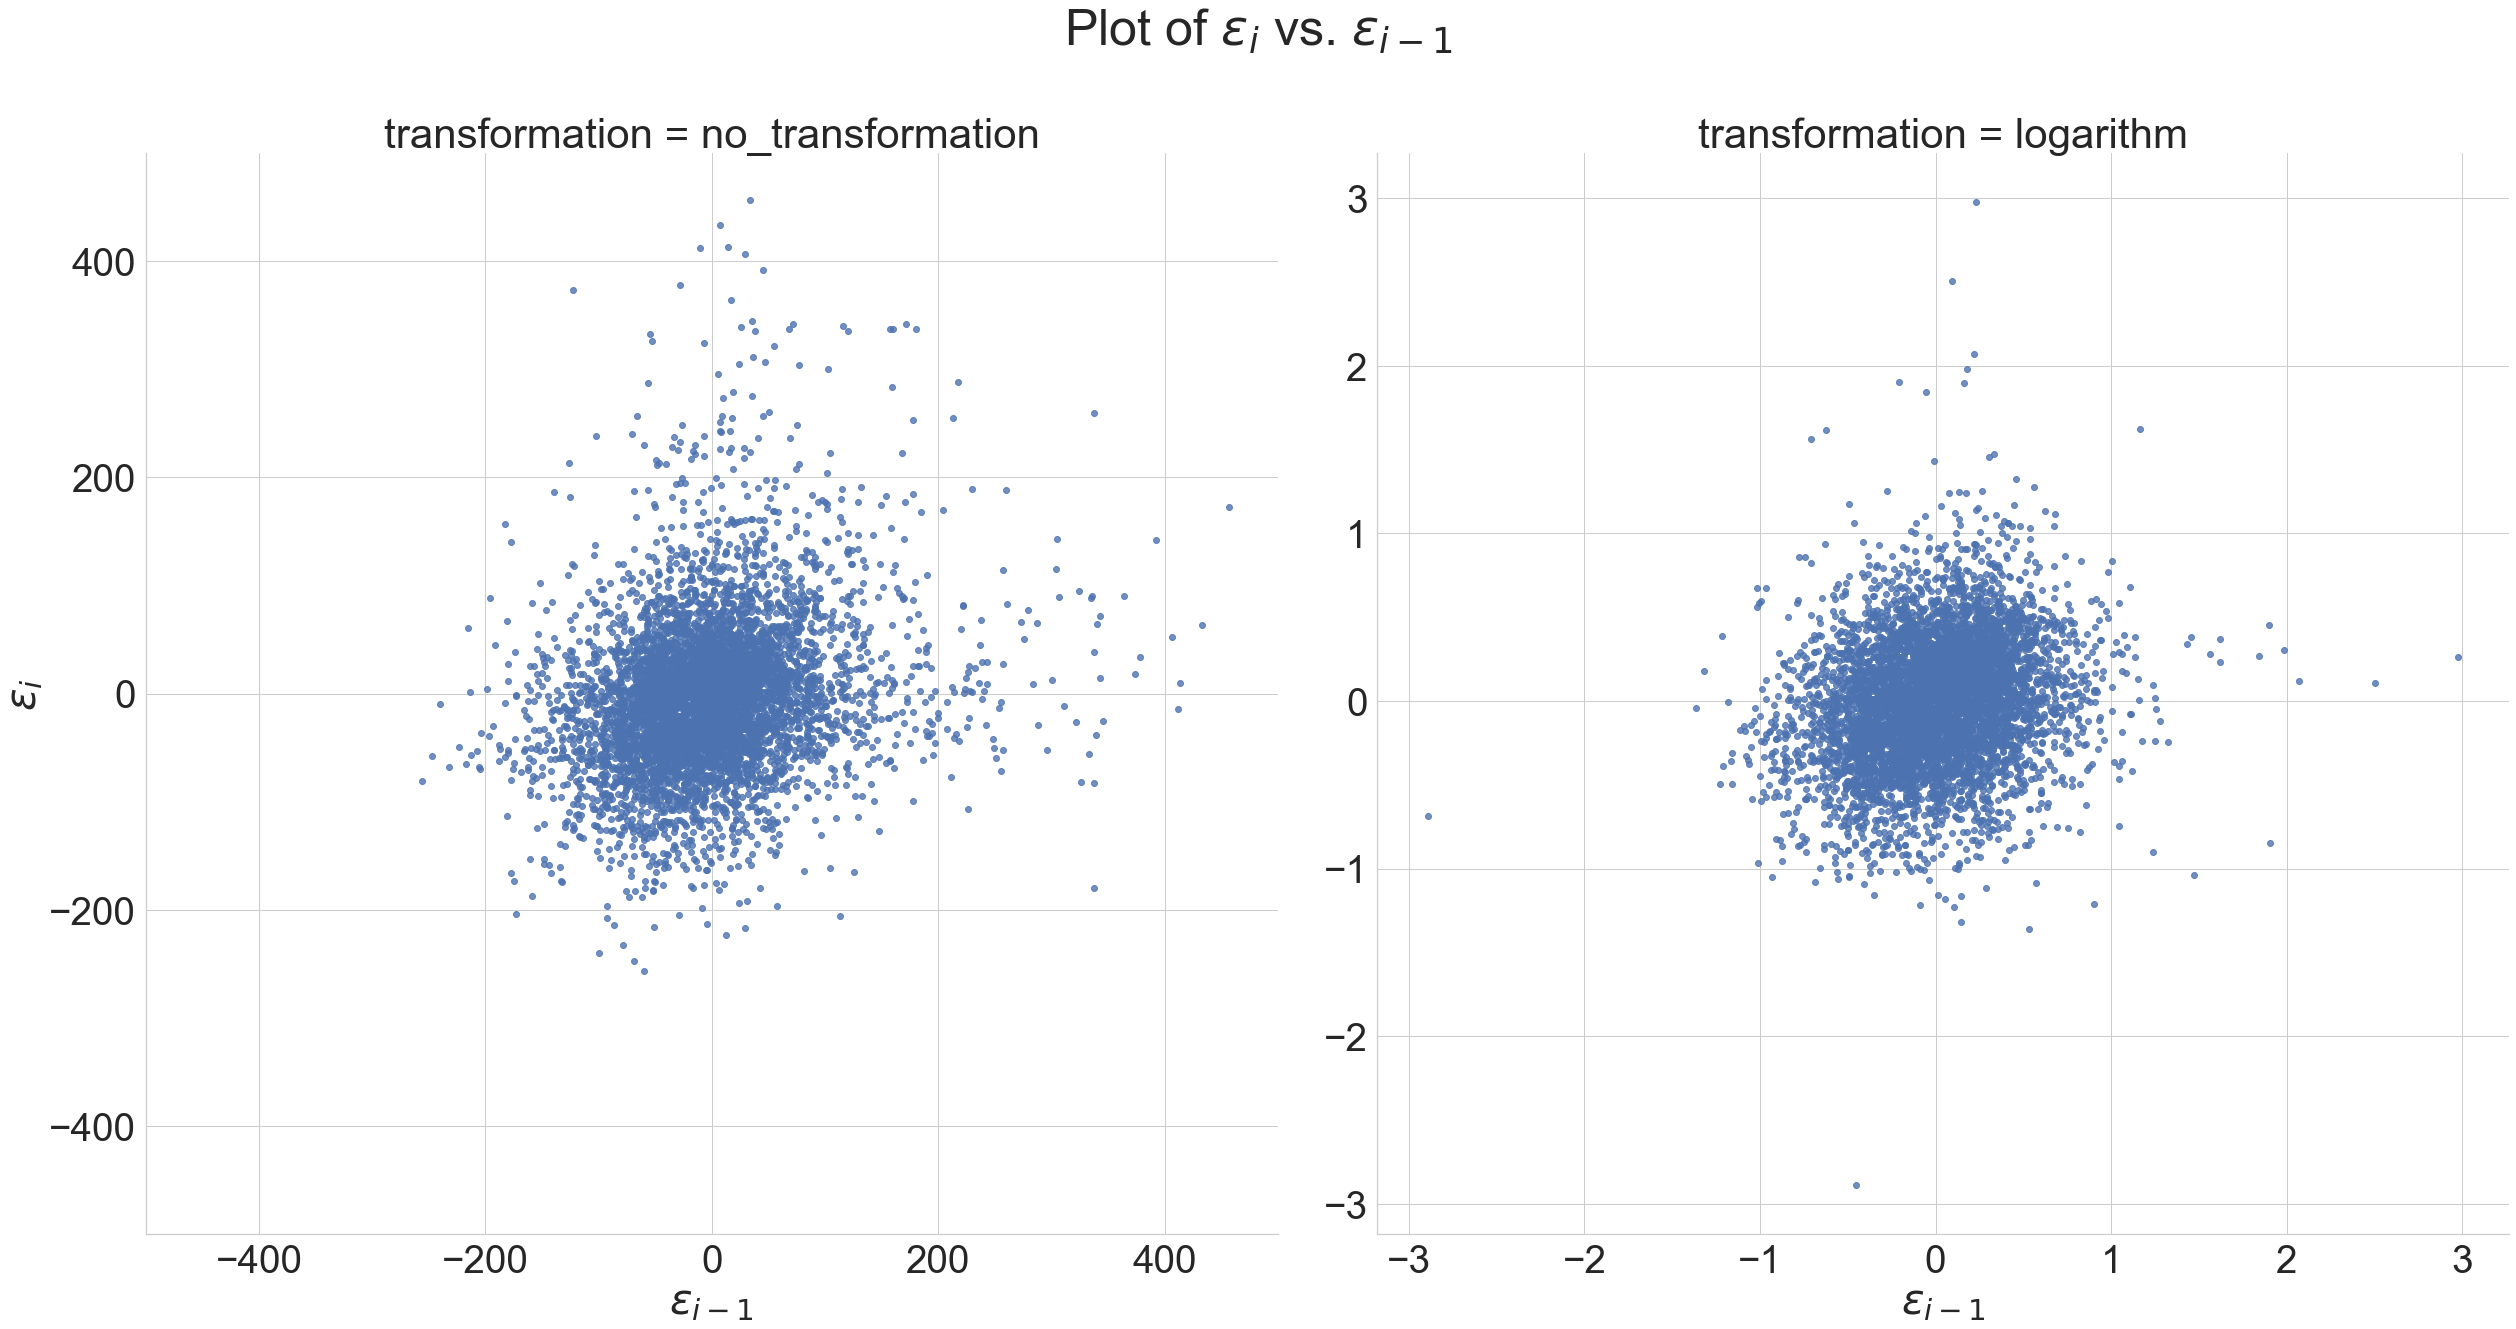

In [57]:
# Make scatterplots of successive residuals faceting on the transformation of the response
sns.set(font_scale=3.5)
sns.set_style('whitegrid')
g = sns.lmplot(x='ep_m_1', y='ep', data=resid_combined, col='transformation',
               fit_reg=False, facet_kws={'sharex':False, 'sharey':False}, height=18)
axes = g.axes
axes[0, 0].set_ylim(-500, 500)
axes[0, 0].set_xlim(-500, 500)
g.fig.suptitle(r'Plot of $\epsilon_i$ vs. $\epsilon_{i-1}$', y=1.05)
g.set_xlabels(r'$\epsilon_{i-1}$')
g.set_ylabels(r'$\epsilon_{i}$')
plt.show()

In [58]:
# Make a dataframe of the fitted values and residuals of each of the linear models of mean_price and log_mean_price
model_adequacy_df = pd.DataFrame({'fitted_values':lm.fittedvalues,
              'residuals':lm.resid,
              'transformation':'no_transformation'})
model_adequacy_df = model_adequacy_df[model_adequacy_df['residuals'] < 500]
model_adequacy_df = pd.concat([model_adequacy_df, pd.DataFrame({'fitted_values':lm_log.fittedvalues,
                                             'residuals':lm_log.resid,
                                             'transformation':'logarithmic'})], ignore_index=True)

<a id='ca3'></a>

#### Assumption 3: Error terms have constant variance
In each of the below plots we plot the residuals vs. the fitted values.

1. The left scatterplot indicates a funnel-like pattern in the residuals indicating a variance among the error terms that is _not_ constant.

2. The right scatterplot indicates a constant variance.

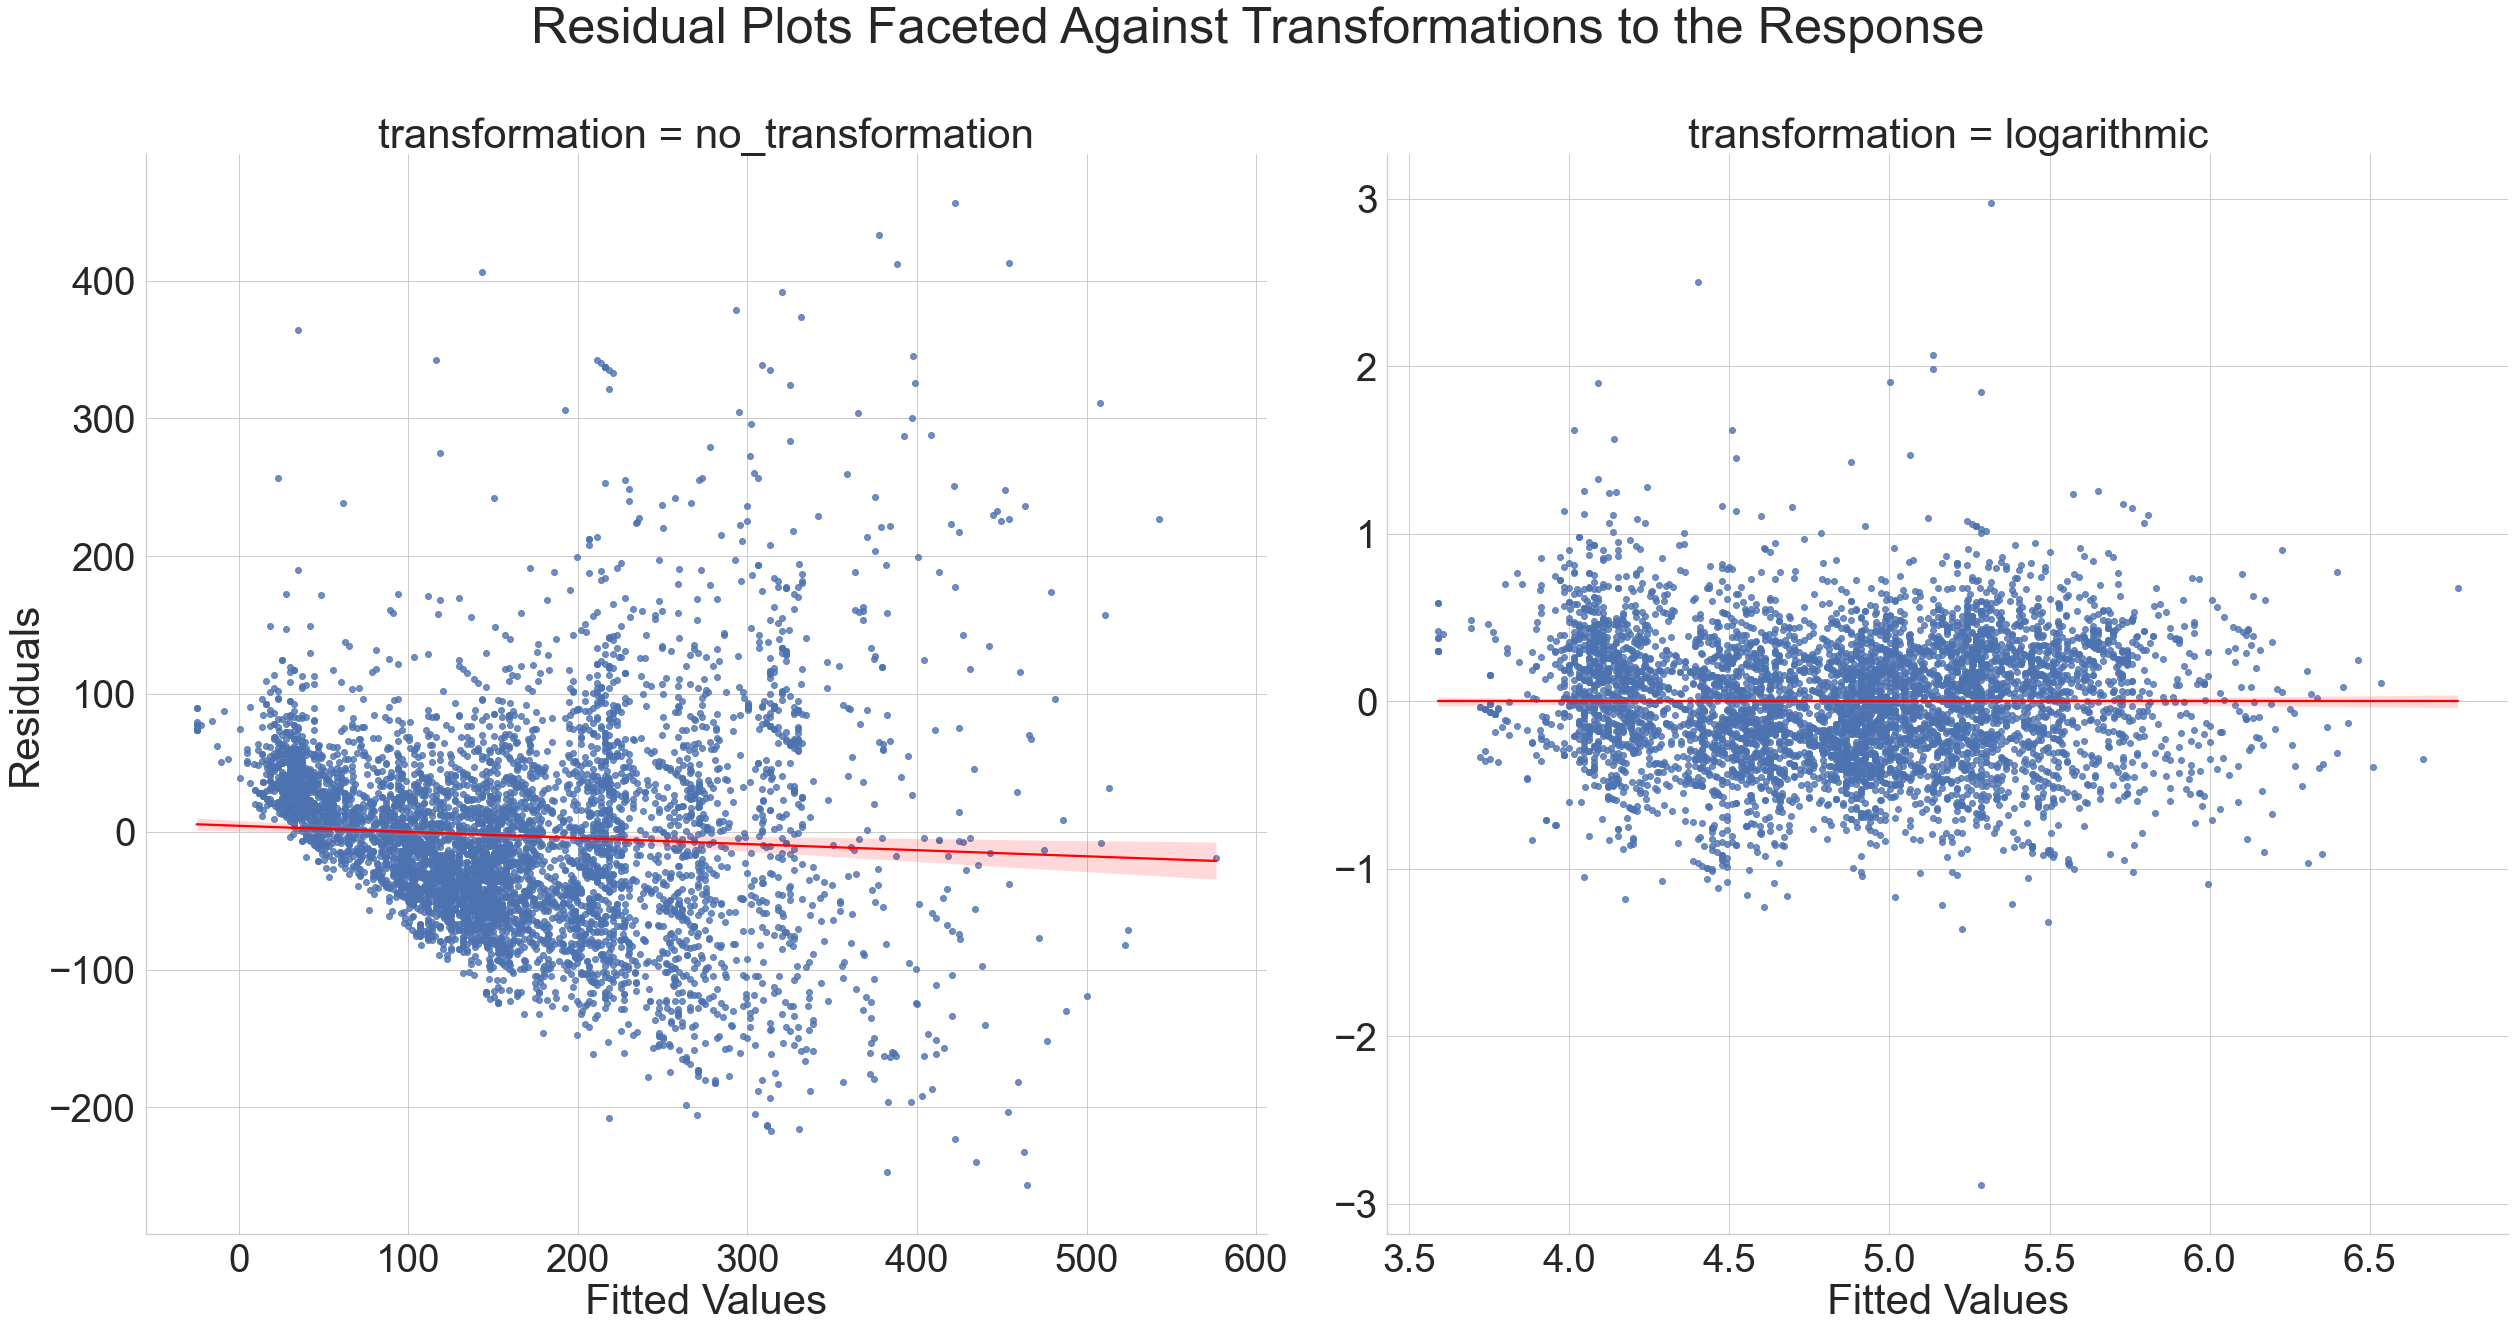

In [59]:
# Make scatterplots of the residuals vs. fitted values plots faceting on the transformation of the respone
# in the linear model
sns.set(font_scale=3.5)
sns.set_style('whitegrid')
g = sns.lmplot(x='fitted_values', y='residuals', data=model_adequacy_df, col='transformation',
               facet_kws={'sharex':False, 'sharey':False}, line_kws={'color':'red'},
               height=18)
g.fig.suptitle('Residual Plots Faceted Against Transformations to the Response', y=1.05)
g.set_ylabels(label='Residuals')
g.set_xlabels(label='Fitted Values')
plt.show()

<a id='ca4'></a>

#### Assumption 4: The error terms are normally distributed
In each of the two plots below I give the histogram of residuals from the two regression models.

1. Left: the distribution of the data seems to be right skewed because of the long tail that extends to the right (larger values).

2. Right: this histogram is a really nice example of a variable, in our case the residuals, that is (standard) normally distributed. I am satisfied from this plot alone that the residuals from the model with the log-transform of **mean_price** are normally distributed - had I been skeptical of their normality, I would give a QQ-Plot as well.

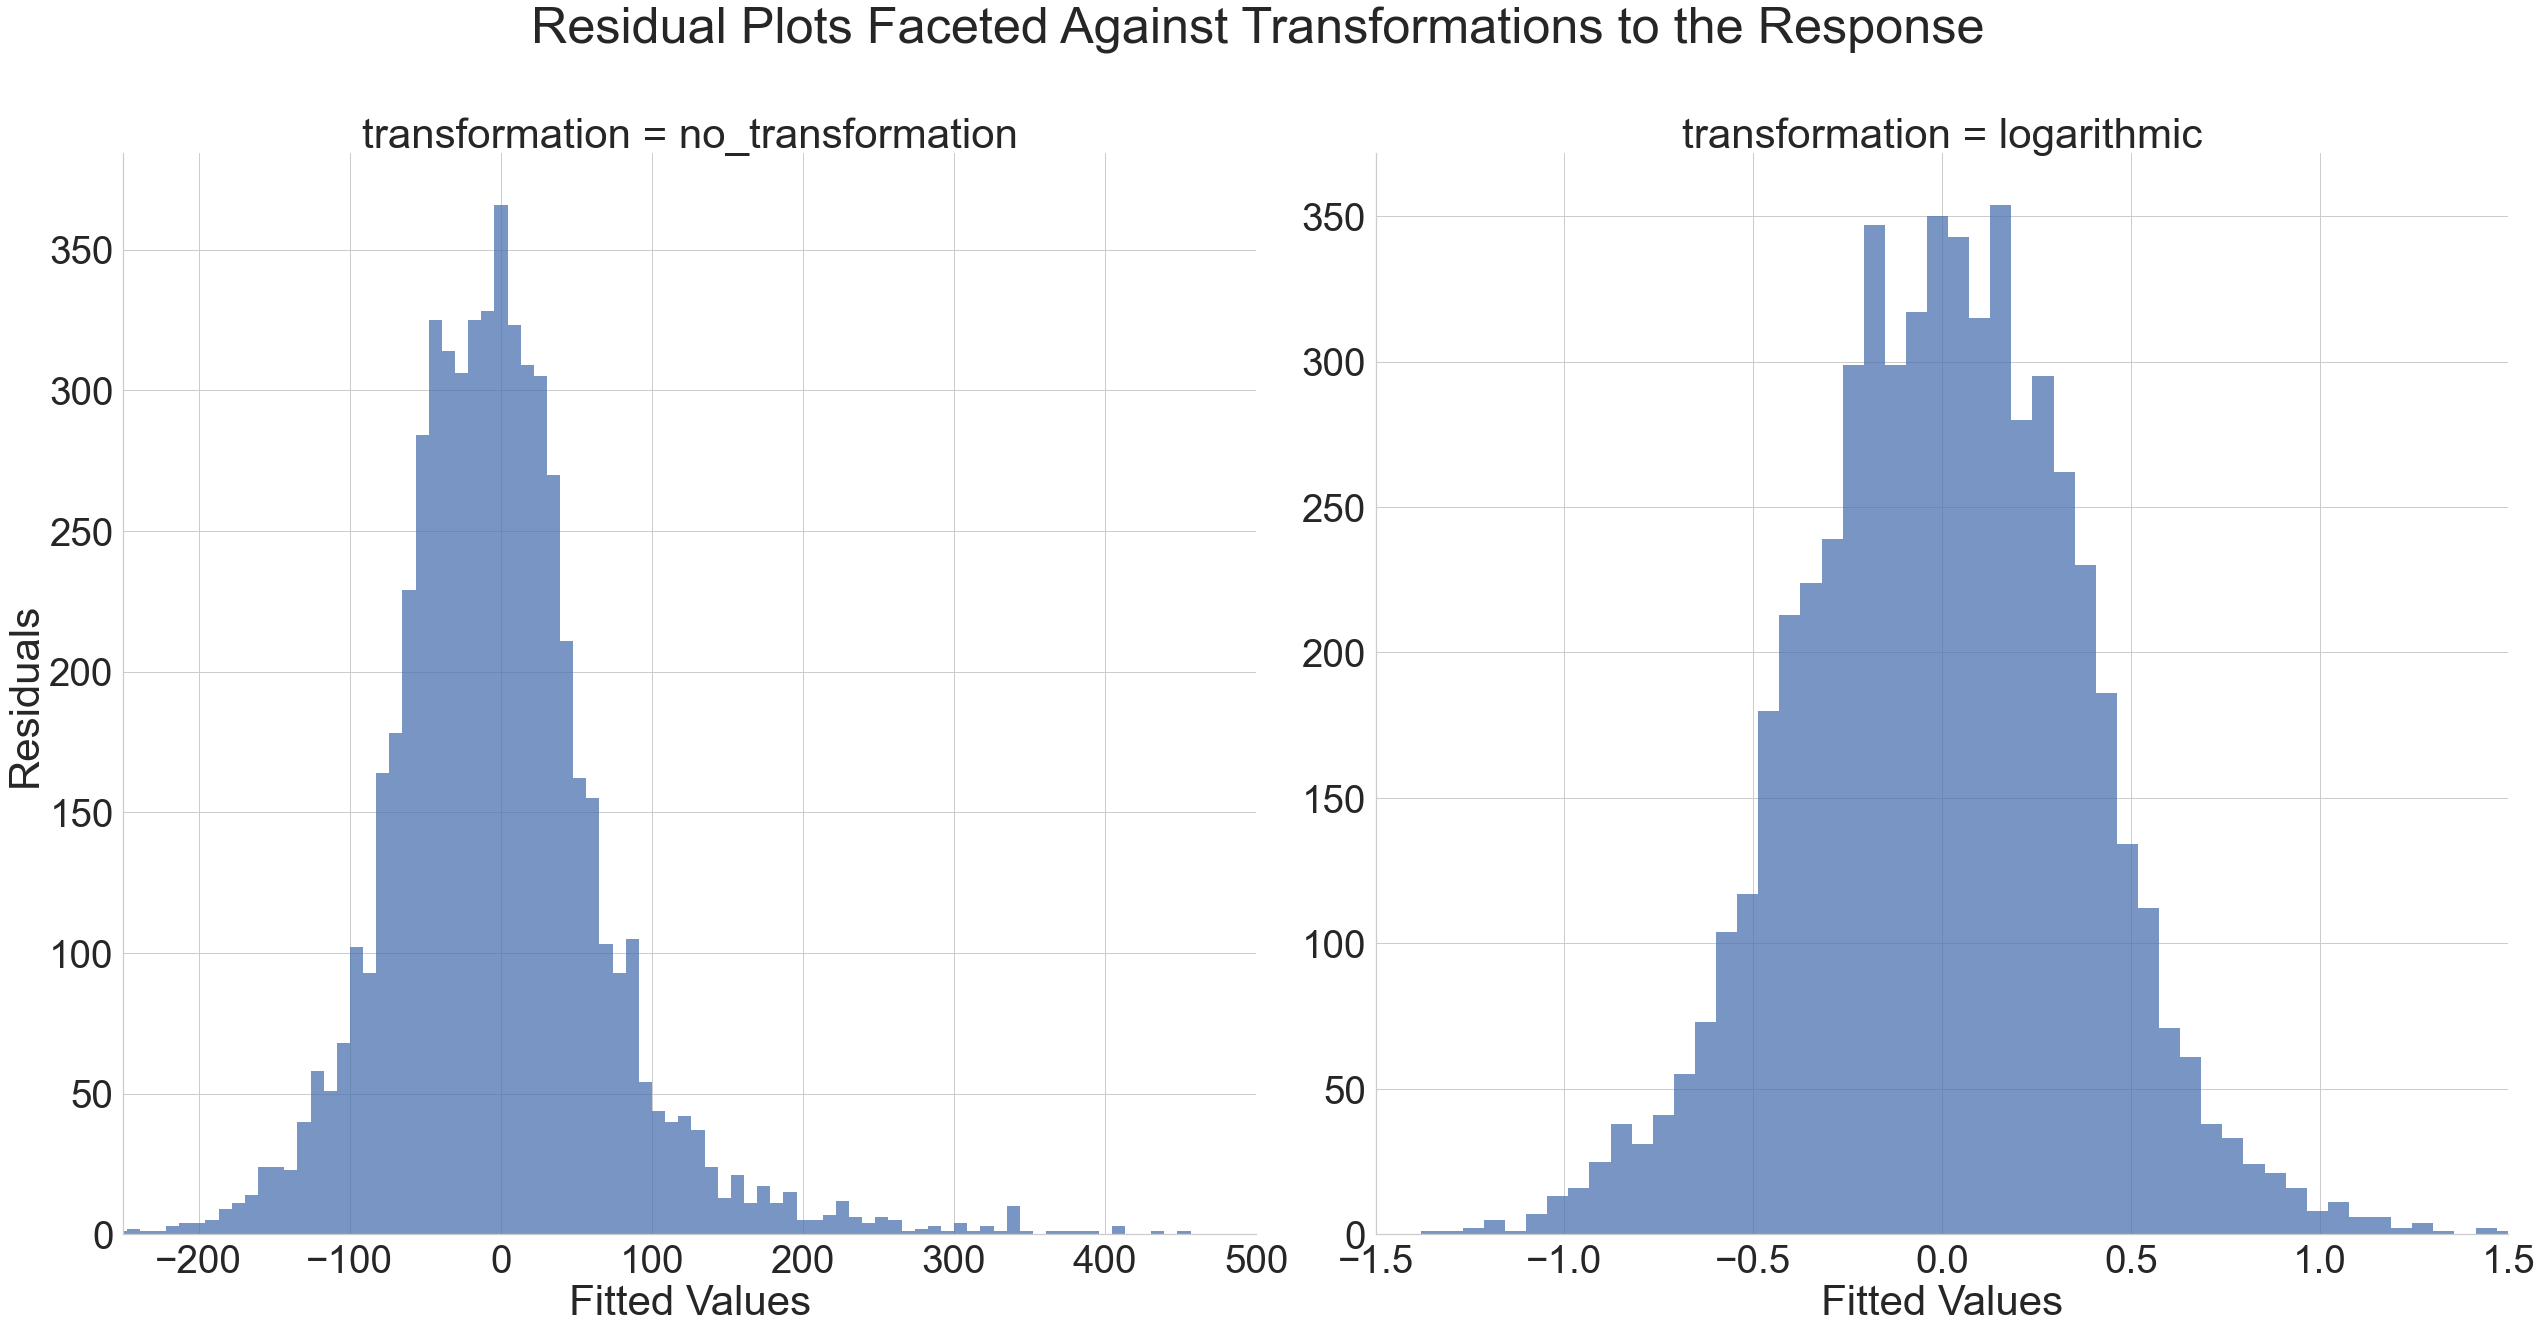

In [60]:
# Make histograms of the residuals faceting on the transformation of the response in the linear model
sns.set(font_scale=3.5)
sns.set_style('whitegrid')
g = sns.displot(x='residuals', data=model_adequacy_df, col='transformation',
               facet_kws={'sharex':False, 'sharey':False}, common_bins=False,
               height=18)
axes = g.axes
axes[0,0].set_xlim(-250, 500)
axes[0,1].set_xlim(-1.5, 1.5)
g.fig.suptitle('Residual Plots Faceted Against Transformations to the Response', y=1.05)
g.set_ylabels(label='Residuals')
g.set_xlabels(label='Fitted Values')
plt.show()

<a id='coefficientsinterpretation'></a>

#### Interpretation of the Coefficients:

#### Evaluate Results:

I will interpret two coefficients, the other coefficients have a similar interpretation:

   1. Seattle coefficient: switching from buying a property in Seattle (as opposed to Boston) decreases the mean daily rental price of a property by 29\%
   
   2. Bedrooms: increasing the number of bedrooms by 1 means a property has will have a 23\% increase in mean daily rental price.

In [61]:
# Make and display the dataframe of the transformed and back-transformed coefficients in the log_mean_price
# linear model
pd.DataFrame({'Transformed Coefficients':lm_log.params[1:],
             'Back Transformed Coefficients':np.exp(lm_log.params[1:])})

,Transformed Coefficients,Back Transformed Coefficients
city[T.Seattle],-0.301091,0.740010
room_type[T.Private room],-0.689091,0.502032
room_type[T.Shared room],-0.997505,0.368798
property_type[T.House],-0.114754,0.891586
bedrooms,0.223156,1.250015
num_amenities,0.015152,1.015268
bathrooms,0.172479,1.188247


<a id='regressionpredictions'></a>

#### Predicting Daily Rental Prices Using the Regression Model with the Log-Transformed **mean_price** as the Response

#### Evaluate Results:

Since the response of **lm_log** is log-transformed, we have to back-transform ($e^{\mathrm{log\_mean\_price}}$) any predictions on price from this model. The code cells below shows the effect that each of the changes in the regressors have on **mean_price** for a property.

_Disclaimer_: I would not recommend this model to anybody/any company for highly accurate predictions on the **mean_price** of a rental property. I have not performed model selection, cross validation, feature engineering/selection, _but_ this model can give a reasonable general idea of the mean price a property should have throughtout the year on airbnb. Recall from the business scenario in the introduction of this notebook that was not my intention.

<a id='model prediction'></a>

In [62]:
# make a datafame of prediction data based on small houses that I might realistically consider
# buying in either city (no large homes in large cities - these would be very expensive)
prediction_data = pd.DataFrame({'bedrooms':[2, 1], 'city':['Boston', 'Seattle'],
                         'room_type':['Entire home/apt', 'Entire home/apt'],
                         'num_amenities':[5, 10],
                         'bathrooms':[2, 1],
                         'property_type':['Apartment', 'Apartment']})

In [63]:
# Back transform the predictions and add them to the prediction_data dataframe
prediction_data = prediction_data.assign(log_mean_price = lm_log.predict(prediction_data))
prediction_data = prediction_data.assign(mean_pirce = np.exp(prediction_data['log_mean_price']))
prediction_data

,bedrooms,city,room_type,num_amenities,bathrooms,property_type,log_mean_price,mean_pirce
0,2,Boston,Entire home/apt,5,2,Apartment,5.455078,233.943178
1,1,Seattle,Entire home/apt,10,1,Apartment,4.834114,125.727139


In [64]:
calendar_listings_drop_na_rev = pd.DataFrame()

<a id='visualize'></a>

## Visualize: Choropleths and Word Clouds

<a id='zipc'></a>

## Question 2: Understanding the Effect of Location on Price and Property Availability
In this question I address how the effects of location affect the vacancy and price of a property for each city _individually_. The variable for price has been averaged for each property over the time period that this data spans for; this is the **mean_price** variable. _I am not using the daily price of a property at the time the data was scraped , namely,_ **price**.

In addition the data were grouped by zipcode and averages were calculted by **zipcode** for **mean_price** and **availability_365**.

_**Note**_: **availability_365** is defined as the number of days in advance (out of 365) that a property is booked according to the calendar at the time the data was scraped; this variable is a good indication of how much general interest there is in a property listed on airbnb and its overall vacancy rate throughout the year.

In [65]:
# Convert the dataframe of boston zipcode geometry objects from a web mercator
# coordinate system to a Longitude/Latitude coordinate system
boston_zip_df.geometry = boston_zip_df.geometry.to_crs(epsg=4326)

In [66]:
boston_listings_calendar = calendar_listings.query('city == "Boston"')
seattle_listings_calendar = calendar_listings.query('city == "Seattle"')

### Property Locations: Boston, MA
The below figure shows the location (in black) of _each individual_ property in Boston. By adjusting the transparency of each point we can see that the greatest density of properties is in _northern_ Boston.

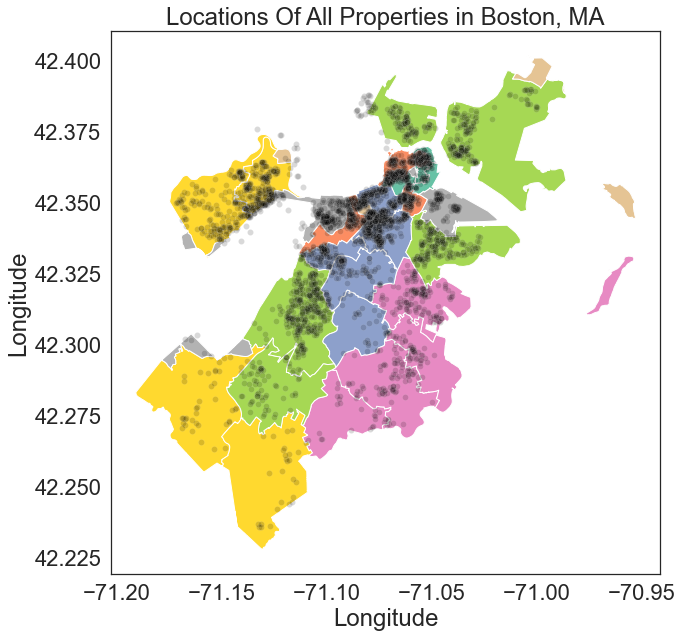

In [67]:
# Make a map showing the location of all of the airbnb property listings in Boston
sns.set(font_scale=2.0)
sns.set_style('white')
fig, ax = plt.subplots(figsize=[15, 10])
legend_kws = {'title':'Zipcode', 'loc':'upper left', 'bbox_to_anchor':(1, 1.03), 'ncol':2}
boston_zip_df.plot(column='ZIP5', legend=False, cmap='Set2', ax=ax, legend_kwds=legend_kws)
sns.scatterplot(x='longitude', y='latitude', data=boston_listings_calendar, color='black', ax=ax, alpha=0.15)
ax.set(xlabel='Longitude', ylabel='Longitude', title='Locations Of All Properties in Boston, MA')
plt.show()

In [68]:
seattle_zip_codes = list(seattle_listings_calendar['zipcode'].unique())

In [69]:
seattle_zip_df_sub = seattle_zip_df[seattle_zip_df['ZIPCODE'].isin(seattle_zip_codes)].copy(deep=True)

### Property Locations: Seattle, WA
The below figure shows the location (in black) of _each individual_ property in Seattle. By adjusting the transparency of each point we can see that the greatest density of properties is in _wester_ Seattle along the coast of Elliot Bay.

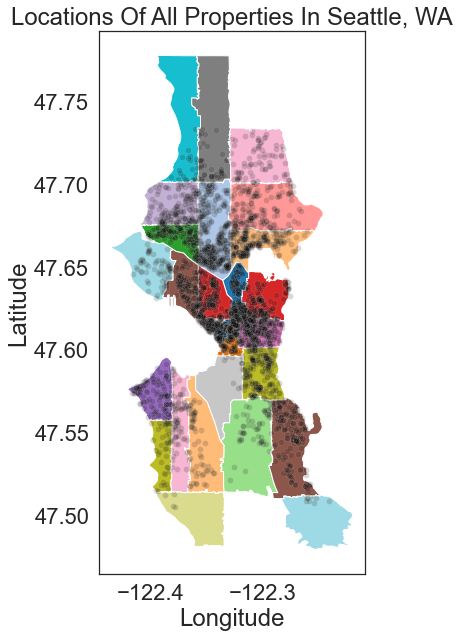

In [70]:
# Make a map showing all of the locations of the property listings in Seattle
fig, ax = plt.subplots(figsize=[15, 10])
legend_kws = {'title':'Zipcode', 'loc':'upper left', 'bbox_to_anchor':(1, 1.03), 'ncol':2}
seattle_zip_df_sub.plot(column='ZIPCODE', legend=False, legend_kwds=legend_kws, cmap='tab20', ax=ax)
sns.scatterplot(x='longitude', y='latitude', data=seattle_listings_calendar, color='black', ax=ax, alpha=0.15)
ax.set(xlabel='Longitude', ylabel='Latitude', title='Locations Of All Properties In Seattle, WA')
plt.show()

In [71]:
# Make dataframes of aggregated and grouped (zipcode) availability_365 and mean_price for both the
# Boston and Seattle dataframes
boston_calendar_listings_gb_zipcode = boston_listings_calendar.groupby('zipcode').mean()[['availability_365', 'mean_price']]
seattle_calendar_listings_gb_zipcode = seattle_listings_calendar.groupby('zipcode').mean()[['availability_365', 'mean_price']]

In [72]:
boston_zip_df = boston_zip_df.merge(boston_calendar_listings_gb_zipcode, left_on=['ZIP5'], right_on=['zipcode']).copy(deep=True)

In [73]:
seattle_zip_df_sub = seattle_zip_df_sub.merge(seattle_calendar_listings_gb_zipcode, left_on=['ZIPCODE'], right_on=['zipcode']).copy(deep=True)

<a id='choropleth1'></a>

### Boston Choropleth: Availability_365 and Price

#### Evaluate Results:

Left: A choropleth shows how the average **availability_365** varies with **zipcode** in Boston, MA. There is a mild trend directed northward indicating that properties in _northern_ Boston tend to be booked _a little_ more throughout the year.

Right: A choropleth shows how the average **mean_price** varies with **zipcode** in Boston, MA. There is a strong _northern_ trend indicating the properties in _northern_ Boston tend to be priced higher.

In [74]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

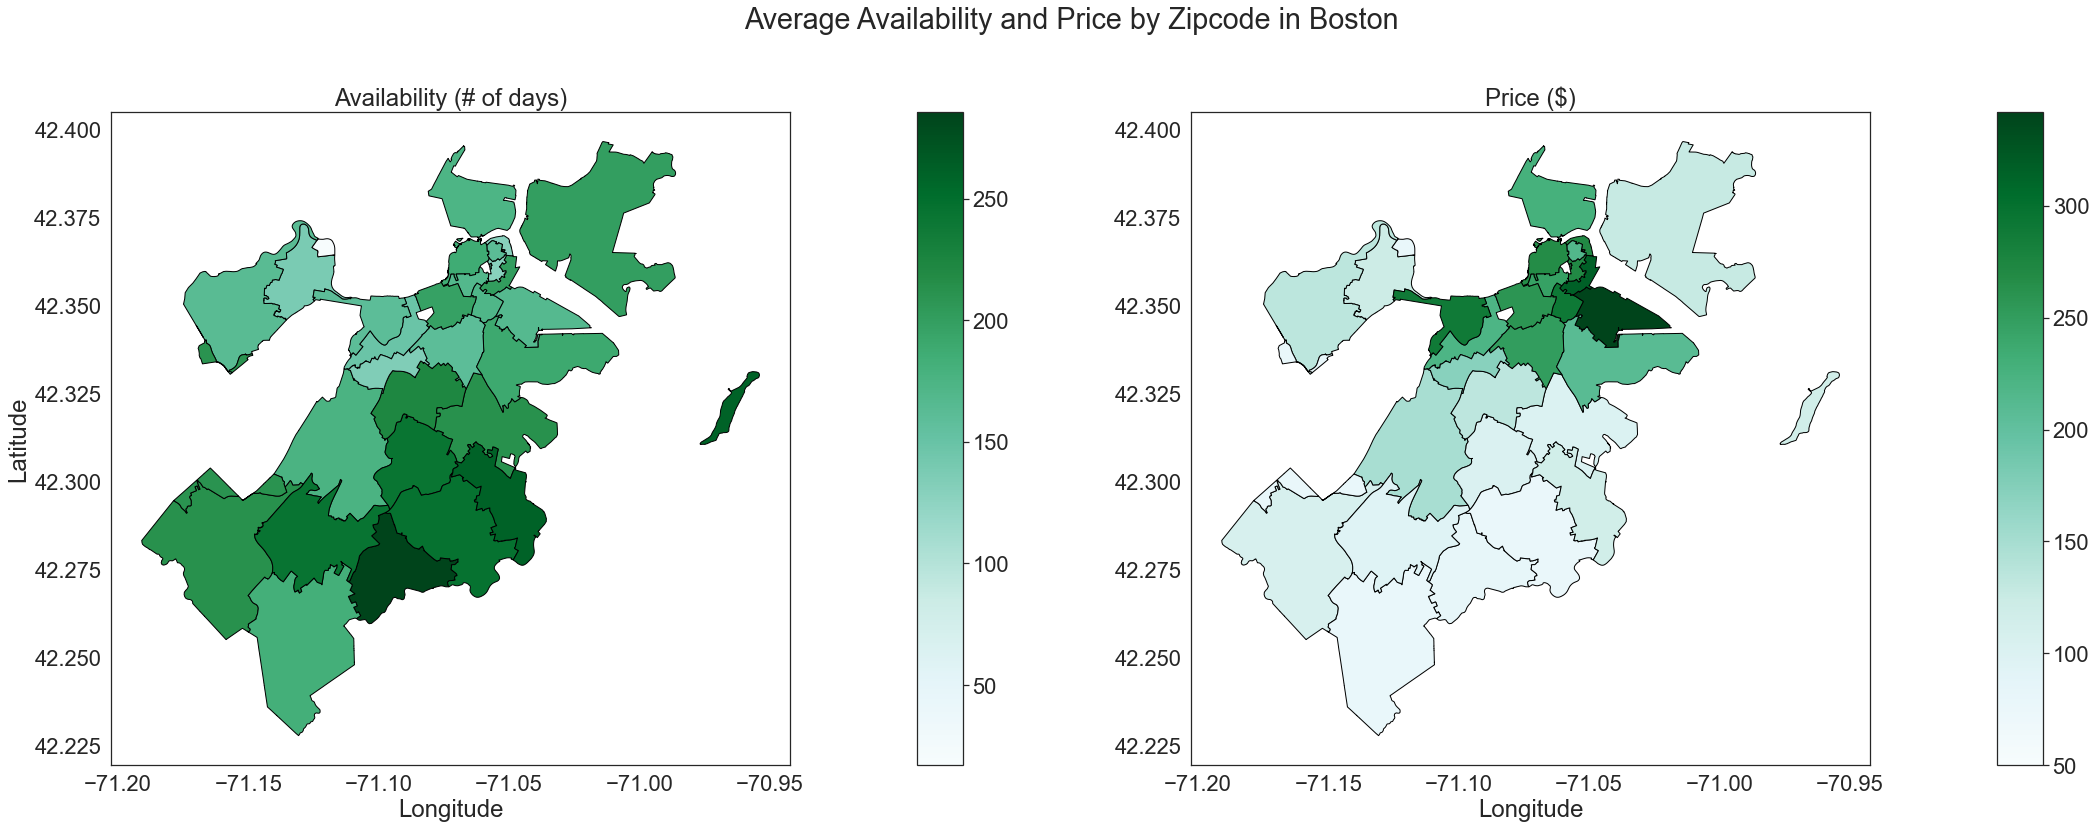

In [75]:
# Make a choropleth of the availability_365 and price for the Boston dataframe
fig, ax = plt.subplots(1, 2,  figsize=[30, 15])
divider1 = make_axes_locatable(ax[0])
divider2 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
boston_zip_df.plot(column='availability_365', legend=True, ax=ax[0], cmap='BuGn', edgecolor='black', cax=cax1)
boston_zip_df.plot(column='mean_price', legend=True, ax=ax[1], cmap='BuGn', edgecolor='black', cax=cax2)
fig.suptitle('Average Availability and Price by Zipcode in Boston', y=0.9)
ax[0].set(xlabel='Longitude', ylabel='Latitude', title='Availability (# of days)')
ax[1].set(xlabel='Longitude', title='Price ($)')
ax[0].set_position([0, 0, 0.45, 1.0])
ax[1].set_position([0.5, 0, 0.45, 1.0])
fig.savefig('./choro_boston.png', format='png')
plt.show()

<a id='choropleth2'></a>

### Seattle Choropleth: Availability_365 and Price
#### Evaluate Results

Left: A choropleth shows how the average **availability_365** varies with **zipcode** in Seattle, WA. There is not an obvious directional trend in how the availability of the property varies by **zipcode**, _but_ we can still see that there are two zipcodes (**98177** and **98109**) where properties tend to be booked more throughout the year.

Right: A choropleth shows how the average **mean_price** varies with **zipcode** in Seattle, WA. There is a strong _westward_ trend indicating the properties along the coast of Elliot Bay in Seattle tend to be priced higher.

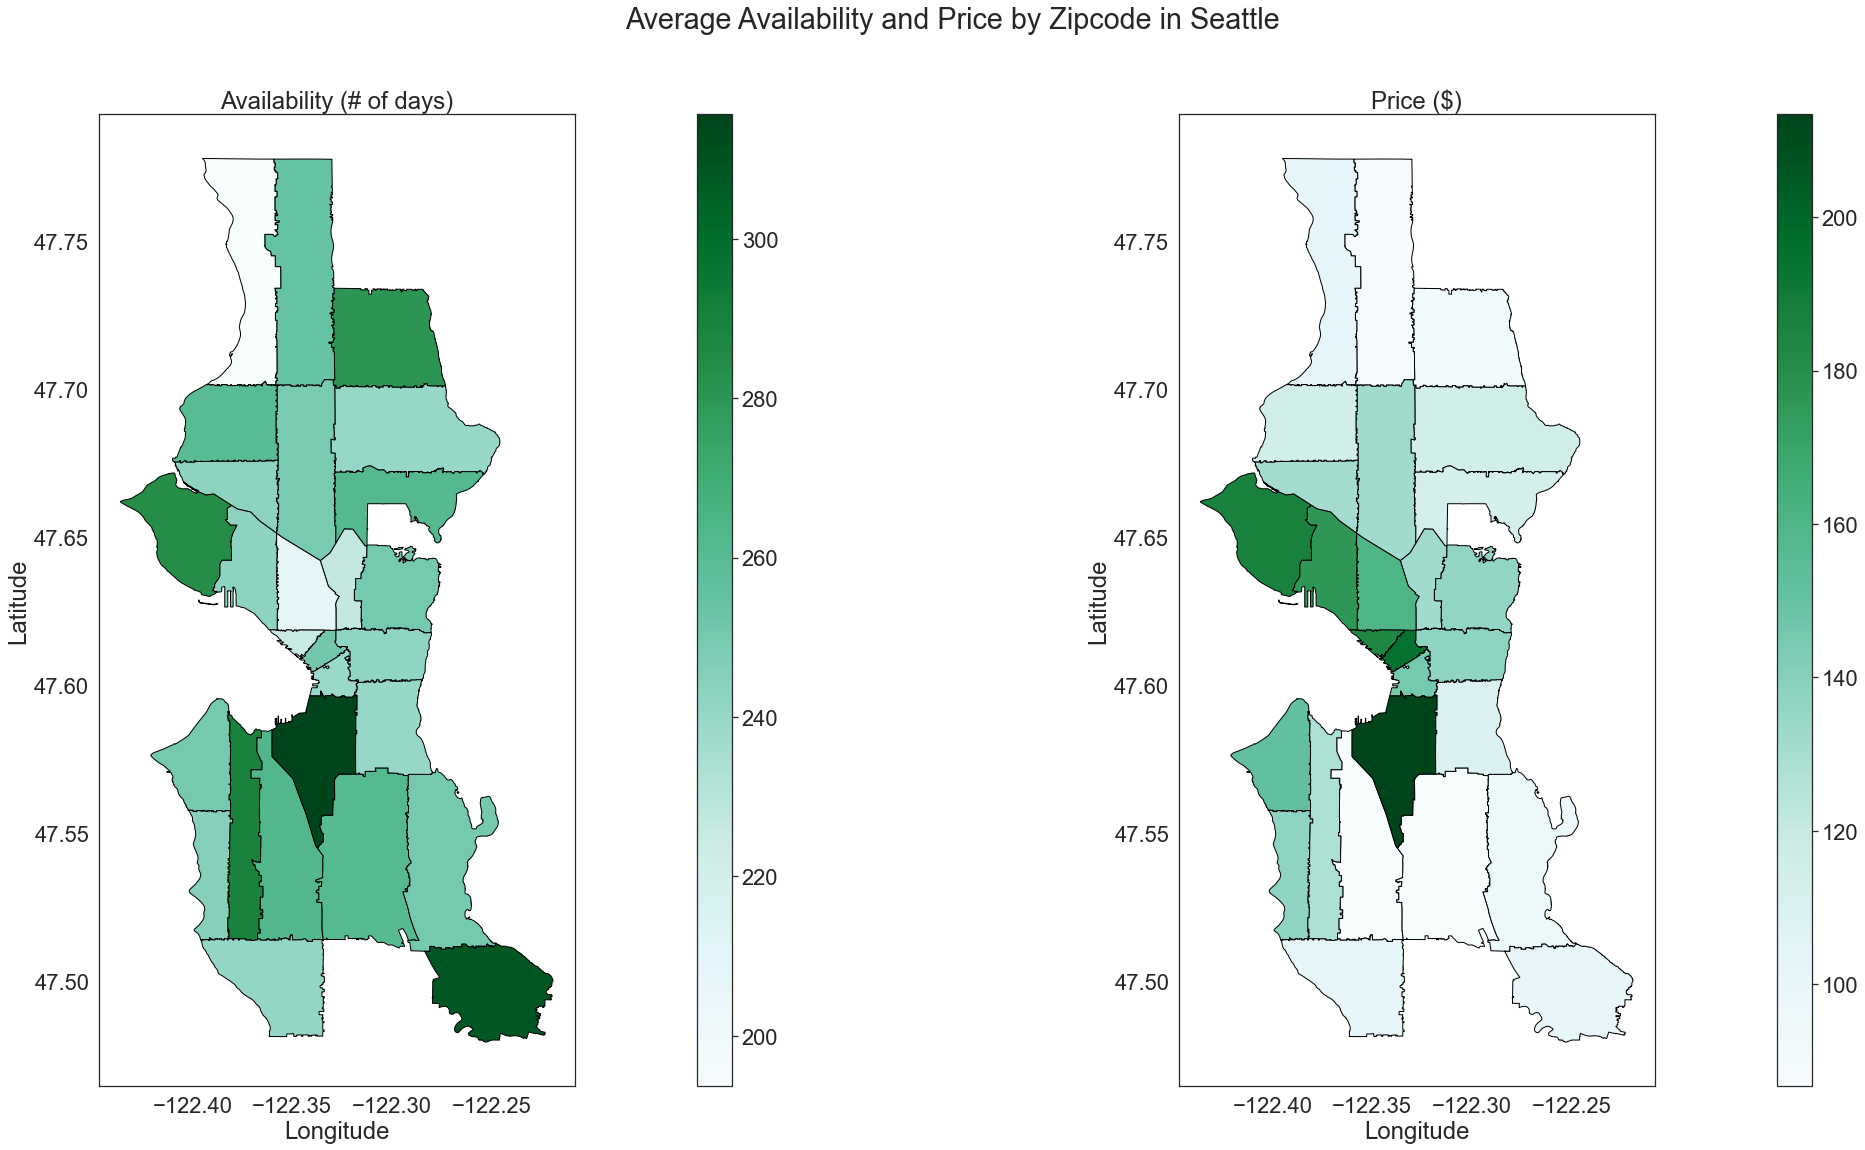

In [76]:
# Make a choropleth of the availability_365 and price for the Seattle dataframe
fig, ax = plt.subplots(1, 2, figsize=[30, 15])
divider1 = make_axes_locatable(ax[0])
divider2 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
seattle_zip_df_sub.plot(column='availability_365', legend=True, ax=ax[0], cmap='BuGn', edgecolor='black', cax=cax1)
seattle_zip_df_sub.plot(column='mean_price', legend=True, ax=ax[1], cmap='BuGn', edgecolor='black', cax=cax2)
fig.suptitle('Average Availability and Price by Zipcode in Seattle', y=1.0)
ax[0].set(xlabel='Longitude', ylabel='Latitude', title='Availability (# of days)')
ax[1].set(xlabel='Longitude', ylabel='Latitude', title='Price ($)')
ax[0].set_position([0, 0, 0.45, 0.9])
ax[1].set_position([0.5, 0, 0.45, 0.9])
fig.savefig('./choro_seattle.png', format='png')
plt.show()

<a id='wordclouds'></a>

## What seem to be recurring themes in properties that received good vs. bad review scores?

### Building a Word Cloud
In the final part of the analysis we build and then analyze the word cloud that is associated with good and bad reviews. This will help the individual decide how strongly to consider things such as location of the property and how to prepare the property (decore, ambience etc.) for being listed on airbnb.

The words in a word cloud are the _n_ most frequent words found in the text - in our case the concatenation of all of the good and bad comments in the reviews for each respective class. The more frequent a word is, then the larger and bolder that letter is in the words cloud.

In the cells that follow we will interpret the word cloud associated with good and bad reviews individually.

In [77]:
calendar_listings_drop_na_rev = calendar_listings.dropna(subset=['review_scores_value']).copy(deep=True)
calendar_listings_drop_na_rev.loc[:, 'review_scores_codes'] = calendar_listings_drop_na_rev['review_scores_value'].cat.codes

In [78]:
calendar_listings_drop_na_rev.review_scores_codes.value_counts()

9    2952
8    2267
7     524
6      89
5      65
3      16
1       8
4       3
2       2
Name: review_scores_codes, dtype: int64

In [79]:
# query the calendar_listings dataframes for low and high review properties
low_reviews = calendar_listings_drop_na_rev.query('review_scores_codes < 5.0')
high_reviews = calendar_listings_drop_na_rev.query('review_scores_codes > 8.0')

In [80]:
# make a dataframe of only low review properties
low_reviews = low_reviews.merge(reviews, left_on=['id'], right_on=['listing_id'])['comments']

In [81]:
# Make a dataframe of only high review properties
high_reviews = high_reviews.merge(reviews, left_on=['id'], right_on=['listing_id'])['comments']

In [82]:
# Concatenate all of the low reviews and high reviews comments into a single string
low_reviews_string = low_reviews.str.cat(sep=' ')
high_reviews_string = high_reviews.str.cat(sep=' ')

In [83]:
# Add certain (uniteresting) stop words to the default NLTK english stop words list
stop_words = set(stopwords.words('english'))

In [84]:
stop_words.add('apartment')
stop_words.add('Boston')
stop_words.add('Seattle')

<a id='badreviews'></a>

### Word Cloud: Bad reviews

#### Evaluate Results:

This word cloud is not as illuminating as the word cloud for the good reviews is. With that being said there are some terms, and even a couple of phrases, that give some hints at problems that are recurring for properties that receive bad reviews.

Firstly, notice that the word 'host' is one of the biggest words in the entire cloud. This indicates that maybe there might be several problems that are specific to the host and not to the property.

Secondly the word WiFi, while small, is very specific which maybe indicates that issues with the propertys' WiFi led the guests to leave a poor review.

Notice that the word _location_ is moderately large and in bold - this indicates that guest might not have liked the location of the property.

Lastly, notice that the words _clean_, _kitchen_, _bathroom_, _bed_ and _room_ are all fairly large. This could indicate that properties that lack cleanliness in general (and maybe even these specific areas) recieved bad reviews.

Of course, you would need to read each individual review to be sure, but the word cloud does give strong hints to issues that people that left bad reviews had with the property.

In [85]:
# Generate and display the word cloud for low review properties
word_cloud_low_reviews = WordCloud(max_font_size=50, max_words=50, background_color='white',
                                   stopwords=stop_words).generate(low_reviews_string)
word_cloud_low_reviews.to_file('bad_reviews.png');

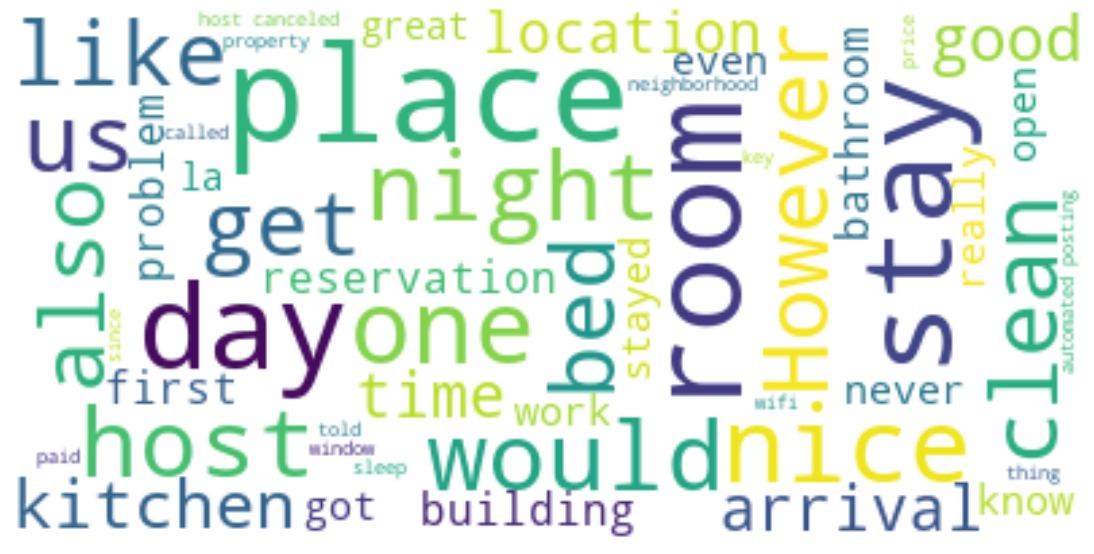

In [86]:
#plt.figure(figsize=[15, 10])
fig, ax = plt.subplots(figsize=[15, 10])
plt.imshow(word_cloud_low_reviews, interpolation='bilinear')
plt.axis('off')
ax.set_position([0, 0, 1, 1])
fig.savefig('./bad_reviews.png', format='png')
plt.show()

<a id='goodreviews'></a>

### Word Cloud: Good reviews

#### Evaluate Results:

This word cloud is a bit more enlightening than the one for the bad reviews - many of the words are _bold_ and large indicating a more occurrences of each of the words in the word cloud.

First off, the biggest boldest word in the cloud is 'clean' indicating that properties that were _clean_ acquired the highest review scores.

Next, one of the largest and boldest words in the cloud is 'comfortable' which indicates that a guests comfort was a strongly recurring theme for properties that received the highest reviews - of course, this is a bit obvious but more keywords in the cloud will shed a little more light on what made a guests stay comfortable while at a property. The words 'welcoming', 'cozy', 'lovely', 'space', 'beautiful' and 'room' are also in the word cloud. Together, all of these words indicate that a property that is well furnished and well decorated will acquire higher review scores. So, decore might play a large role in whether or not a property receives a good review.

Thirdly, the phrase/words 'walking distance', 'location', 'downtown', and 'neighborhood' are also small to medium sizes and boldness in the word cloud. This indicates that location with respect to the venues that guests want to attend are important and contribute a moderate-large amount to a guests decision for leaving a high review score.

Lastly, the phrases/words 'great host', 'helpful', 'friendly' and 'welcoming' indicate that hosts that went above and beyond contributed a moderate amount to properties that acquired high review scores.

In [87]:
# Generate and display the word cloud for high review properties
word_cloud_high_reviews = WordCloud(max_font_size=50, max_words=50, background_color='white',
                                    stopwords=stop_words).generate(high_reviews_string)

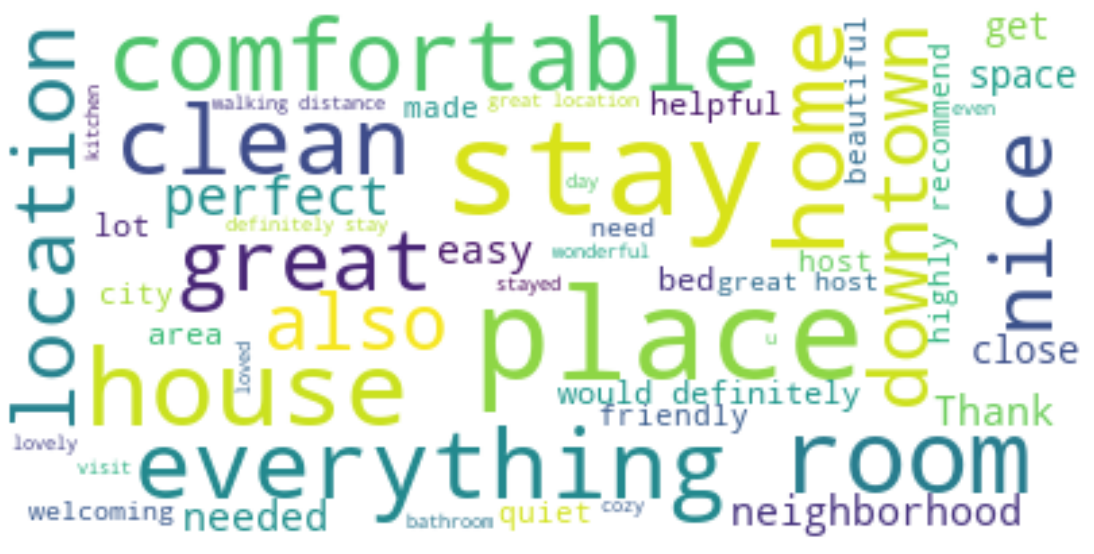

In [88]:
#plt.figure(figsize=[15, 10])
fig, ax = plt.subplots(figsize=[15, 10])
plt.imshow(word_cloud_high_reviews, interpolation='bilinear')
plt.axis('off')
ax.set_position([0, 0, 1, 1])
fig.savefig('./good_reviews.png', format='png')
plt.show()